# SET UP

In [1]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt # plotting
%matplotlib inline
import time
import os
import pandas as pd
import shutil
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# library used to process audio 
import librosa
from librosa import display
import IPython.display as ipd

plt.figure(figsize=(14,5))
DATAPATH = './archive'
dir_list = os.listdir(DATAPATH)
print(dir_list)
#print(os.listdir(os.path.join(DATAPATH,dir_list[0])))

from vscode_audio import Audio
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPool2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Lambda
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


<Figure size 1008x360 with 0 Axes>

In [2]:
from tensorflow.python.client import device_lib
tf.config.experimental.list_physical_devices('GPU')
print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17859821426605096211
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6963920896
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7912773438180692666
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]
Num GPUs Available:  1


# takes a look at the audio and visualize it

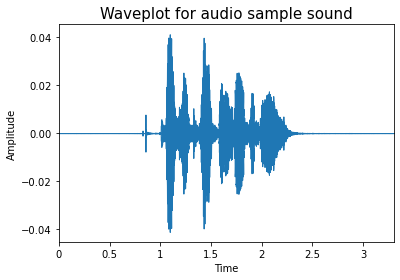

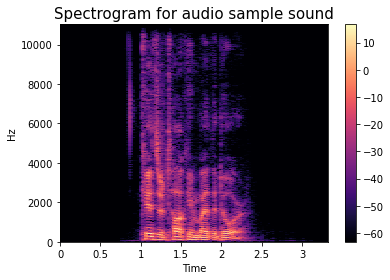

In [3]:
testpath = os.path.join(DATAPATH, "Actor_01/03-01-01-01-01-01-01.wav")
def generate_sound(path):
    ipd.Audio(path)
def generate_waveplot(path, title):
    plt.title('Waveplot for audio {}'.format(title), size=15)
    x,fs = librosa.load(testpath)
    librosa.display.waveplot(x, sr=fs)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.savefig("./plots/waveplot.png")
    plt.show()

def generate_spectrogram(path, title):
    x,fs = librosa.load(testpath)
    x = librosa.stft(x)
    x = librosa.amplitude_to_db(abs(x))
    plt.title('Spectrogram for audio {}'.format(title), size=15)
    librosa.display.specshow(x, sr=fs, x_axis='time', y_axis='hz')  
    plt.savefig("./plots/spectrogram.png")
    plt.colorbar()
generate_sound(testpath)
generate_waveplot(testpath, "sample sound")
generate_spectrogram(testpath,"sample sound")

In [4]:
data, rate = librosa.load(testpath)

# Emotion Representation
https://www.youtube.com/watch?v=26_qiXEa8lw
* three Dimensional
 * Valence (negative - positive)
 * Activation (low - high)
 * Dominance (Dominated - dominant)
* Two Dimensional
 * arousal
 * valence

* features
 * zero-crossing rate
 * chroma_stft
 * chroma_cqt
 * chroma_cens
 * mel-frequency cepstral coefficient
 * root mean square value
 * melspectogram

# Zero-Crossing Rate
https://academic.microsoft.com/topic/2776860830/publication/search?q=Zero-crossing%20rate&qe=And(Composite(F.FId%253D2776860830)%252CTy%253D%270%27)&f=&orderBy=0 <br/>

is the rate at which a signal changes from positive to negative or from negative to positive. is a key feature to classify percussive sounds

In [5]:
test_zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
len(test_zcr)

1

In [6]:
stft = np.abs(librosa.stft(data))
test_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=rate).T, axis=0)
len(test_stft)

12

# Mel-Frequency Cepstral Coefficient
https://www.youtube.com/watch?v=4_SH2nfbQZ8 <br />
https://en.wikipedia.org/wiki/Mel-frequency_cepstrum
* cepstral 
$C(x(t)) = F^{-1}[log(F[x(t)])]$
* MFCCs advantages
 * Describe the "large" structures of the spectrum
 * ignore fine spectral structures, really don't care on the pitch, etc.
 * work wll in speech and music processing
* MFCCs are commonly used as features in speech recognition systems, such as the systems which can automatically recognize numbers spoken into a telephone

In [7]:
test_mfcc = np.mean(librosa.feature.mfcc(y=data, sr=rate).T, axis=0)
len(test_mfcc)

20

In [8]:
test_rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
len(test_rms)

1

In [9]:
test_mels = np.mean(librosa.feature.melspectrogram(y=data, sr=rate).T, axis=0)
len(test_mels)

128

In [10]:
cqt = np.mean(librosa.feature.chroma_cqt(y=data, sr=rate).T, axis=0)
len(cqt)

12

In [11]:
cens = np.mean(librosa.feature.chroma_cens(y=data, sr=rate).T, axis=0)
len(cens)

12

# Data Augmentation

* noise
* time shifting
* time stretching
* pitch shifting

Data augmentation is a method for generating synthetic data

Sound wave has following characteristics: Pitch, Loudness, Quality. We need to alter our samples around these characteristics in such a way that they only differ by small factor from original sample.


In [7]:
def noise(wav, p):
    return wav + p*np.random.normal(0,1,len(wav))
def time_shifting(wav,p):
    return np.roll(wav,p)
def time_stretching(wav,p):
    return librosa.effects.time_stretch(wav,p)
def pitch_shifting(wav,sr, p):
    return librosa.effects.pitch_shift(wav,sr,n_steps=p)


In [13]:

ipd.Audio(data, rate=rate)

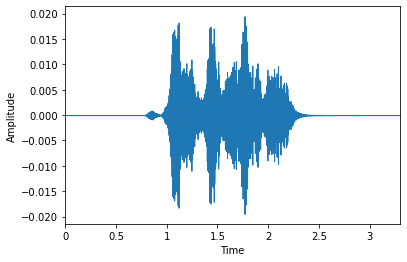

In [8]:

librosa.display.waveplot(pitch_shifting(data,rate,-5), sr=rate)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

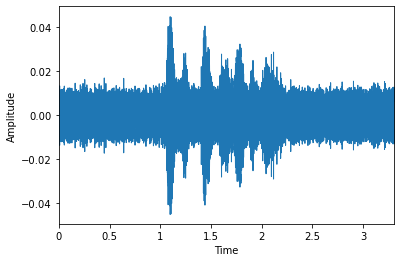

In [9]:
librosa.display.waveplot(noise(data,0.004), sr=rate)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [15]:
ipd.Audio(noise(data,0.004),rate=rate)

In [16]:
ipd.Audio(time_shifting(data,int(rate*100)),rate=rate)

In [17]:
ipd.Audio(time_stretching(data,0.5),rate=rate)

In [18]:
ipd.Audio(pitch_shifting(data,rate,-5),rate=rate)

# Extract data


using MFCC to summary the frequency distribution, and use to identify features for classification

In [19]:
mfccs = librosa.feature.mfcc(y=data,sr=rate,n_mfcc=40)
print(mfccs.shape)

(40, 143)


In [10]:
def files_info_extractor(path):
    dir_list = os.listdir(path)
    y = []
    X = []
    for i in range(len(dir_list)):
        files = os.listdir(os.path.join(path,dir_list[i]))
        for j in range(len(files)):
            X.append([files[j],
                      int(files[j][0:2]),
                     int(files[j][3:5]),
                     int(files[j][6:8]),
                     int(files[j][9:11]),
                    int(files[j][12:14]),
                    int(files[j][15:17]),
                    int(files[j][18:20])])
    return X
info = files_info_extractor(DATAPATH)
info_df = pd.DataFrame(info, columns =["Url", 
                               'Modality', 
                               'Vocal channel',
                              'Emotion',
                              'Emotional intensity',
                              'Statement',
                              'Repetition',
                              'Actor'])


In [11]:
info_df

Url  Modality  Vocal channel  Emotion  \
0     03-01-01-01-01-01-01.wav         3              1        1   
1     03-01-01-01-01-02-01.wav         3              1        1   
2     03-01-01-01-02-01-01.wav         3              1        1   
3     03-01-01-01-02-02-01.wav         3              1        1   
4     03-01-02-01-01-01-01.wav         3              1        2   
...                        ...       ...            ...      ...   
1435  03-01-08-01-02-02-24.wav         3              1        8   
1436  03-01-08-02-01-01-24.wav         3              1        8   
1437  03-01-08-02-01-02-24.wav         3              1        8   
1438  03-01-08-02-02-01-24.wav         3              1        8   
1439  03-01-08-02-02-02-24.wav         3              1        8   

      Emotional intensity  Statement  Repetition  Actor  
0                       1          1           1      1  
1                       1          1           2      1  
2                       1          2           1      1  
3                       1          2           2      1  
4                       1          1           1      1  
...                   ...        ...         ...    ...  
1435                    1          2           2     24  
1436                    2          1           1     24  
1437                    2          1           2     24  
1438                    2          2           1     24  
1439                    2          2           2     24  

[1440 rows x 8 columns]

In [12]:
info_df["Emotion"].value_counts()

2    192
3    192
4    192
5    192
6    192
7    192
8    192
1     96
Name: Emotion, dtype: int64

C:\Users\15197\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


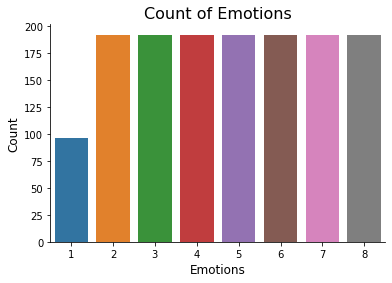

In [13]:
plt.title('Count of Emotions', size=16)
sns.countplot(info_df["Emotion"])
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.savefig("./plots/count_of_emotins.png")
plt.show()

In [25]:
def transfer_all_audios():
    actors = os.listdir(DATAPATH)
    for actor in actors:
        audios = os.listdir(os.path.join(DATAPATH,actor))
        for audio in audios:
            shutil.copy2(os.path.join(DATAPATH,actor,audio), os.path.join("audios",audio))
os.system("mkdir audios")
os.system("rm -r audios/*")
transfer_all_audios()

<h2> create function to exctract the features of an audio </h2>

In [14]:
def generate_zcr(data,rate):
    return np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
def generate_stft(data,rate):
    stft = np.abs(librosa.stft(data))
    return np.mean(librosa.feature.chroma_stft(S=stft, sr=rate).T, axis=0)
def generate_mfcc(data,rate):
    return np.mean(librosa.feature.mfcc(y=data, sr=rate).T, axis=0)

def generate_rms(data, rate):
    return np.mean(librosa.feature.rms(y=data).T, axis=0)
def generate_mels(data, rate):
    return np.mean(librosa.feature.melspectrogram(y=data, sr=rate).T, axis=0)
def generate_cqt(data, rate):
    return np.mean(librosa.feature.chroma_cqt(y=data,sr=rate).T,axis=0)
def generate_cens(data, rate):
    return np.mean(librosa.feature.chroma_cens(y=data,sr=rate).T, axis=0)

In [15]:
def featuresGenerator(data,rate,paras):
    features = np.array([])
    for para in paras:
        if (para == "zcr"):
            features = np.hstack((features,generate_zcr(data, rate)))
        elif (para=="stft"):
            features = np.hstack((features,generate_stft(data, rate)))
        elif (para=="mfcc"):
            features = np.hstack((features,generate_mfcc(data, rate)))
        elif (para == "rms"):
            featurse = np.hstack((features,generate_rms(data, rate)))
        elif (para == "mels"):
            features = np.hstack((features,generate_mels(data, rate)))
        elif (para == "cqt"):
            features = np.hstack((features,generate_cqt(data, rate)))
        elif (para == "cens"):
            features = np.hstack((features,generate_cens(data,rate)))
        else:
            print("wrong features")
    return features


def extract_feature(path,paras, augs):
    data, rate = librosa.load(path)
    if (len(augs)==0):
        return np.array([featuresGenerator(data,rate,paras)])
    result = np.array(featuresGenerator(data,rate,paras))
    for aug in augs:
        if (aug == "noise"):
            result = np.vstack((result,featuresGenerator(noise(data,0.004),rate,paras)))
        elif (aug == "time_shift"):
            result = np.vstack((result, featuresGenerator(time_shifting(data,int(rate/10)),rate,paras)))
        elif (aug == "time_stretch"):
            result = np.vstack((result, featuresGenerator(time_stretching(data,0.5),rate,paras)))
        elif (aug == "pitch_shift"):
            result = np.vstack((result, featuresGenerator(pitch_shifting(data,rate,-5),rate,paras)))
        else:
            print("wrong augmentation")
    return result

def get_features(paras,augs):
    X = []
    y = [] 
    for i in range(len(info_df)):
        path = os.path.join("audios",info_df["Url"][i])
        features = extract_feature(path,paras,augs)
        for f in features:
            
            X.append(f)
            y.append(info_df["Emotion"][i])

    return X,y


<h2> define callback list </h2>

In [16]:
os.system('mkdir "saved_models"')
filepath = "saved_models/weight-model-improvement-{epoch:02d}-{val_accuracy:.2f}-"+time.strftime("%Y%m%d-%H%M%S")+".h5"
checkpoint = ModelCheckpoint(filepath, monitor="val_accuracy",verbose=1,save_best_only=True, model="max", save_weights_only=False)
earlystopping = EarlyStopping(monitor="val_loss",patience=20,verbose=1,restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, verbose=0,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0,
)
log_csv = CSVLogger("my_logs.csv",separator=',', append=False)
callback_list = [checkpoint,earlystopping,log_csv]
callback_list_with_reduction = [checkpoint,earlystopping,log_csv,reduce_lr]

<h2> define the function to build baseline model which used to be compared with other improved model </h2>

In [15]:
def build(x_train):
    model=Sequential()
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(pd.DataFrame(x_train).shape[1], 1)))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Flatten())
    model.add(Dense(8))
    model.add(Activation('softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    return model

# check the simplest model

In [16]:
X,y = get_features(["mfcc"],[])
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()
print(pd.DataFrame(X))

              0          1          2          3          4          5   \
0    -697.984192  55.228489   0.323863  12.775377   7.396148   0.866224   
1    -693.069702  55.734570  -1.919739  16.408995   8.449354   0.220736   
2    -691.770142  58.350647  -0.165160  13.952125   5.053323   1.489326   
3    -685.237915  56.236691   2.453112  13.566655   6.701949   3.341493   
4    -727.317932  62.764400   2.751275  15.473256   7.763115   2.330714   
...          ...        ...        ...        ...        ...        ...   
1435 -586.762634  25.372396 -17.824156  -1.315452 -15.738236  -9.392014   
1436 -532.757446  38.194206 -15.409904  -5.477151 -15.620424 -13.425549   
1437 -541.550232  30.086676 -18.491722  -2.648303 -14.771161 -17.068848   
1438 -492.985962  24.425610  -6.565718   2.215220 -11.599139  -4.619690   
1439 -518.293823  30.043261  -4.414401  -0.645565  -5.760980  -6.644137   

             6          7          8         9         10        11        12  \
0     -3.550276  -

In [17]:
print(pd.DataFrame(y))

        0    1    2    3    4    5    6    7
0     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4     0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
...   ...  ...  ...  ...  ...  ...  ...  ...
1435  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
1436  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
1437  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
1438  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
1439  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0

[1440 rows x 8 columns]


Epoch 1/200
9/9 [==============================] - 8s 37ms/step - loss: 51.2442 - accuracy: 0.1505 - val_loss: 31.0867 - val_accuracy: 0.1181
Epoch 2/200
9/9 [==============================] - 0s 7ms/step - loss: 24.2756 - accuracy: 0.1285 - val_loss: 19.8860 - val_accuracy: 0.1528
Epoch 3/200
9/9 [==============================] - 0s 7ms/step - loss: 12.1801 - accuracy: 0.1528 - val_loss: 5.7430 - val_accuracy: 0.1944
Epoch 4/200
9/9 [==============================] - 0s 7ms/step - loss: 5.0746 - accuracy: 0.1910 - val_loss: 3.8908 - val_accuracy: 0.2153
Epoch 5/200
9/9 [==============================] - 0s 7ms/step - loss: 4.1789 - accuracy: 0.1933 - val_loss: 3.5008 - val_accuracy: 0.1458
Epoch 6/200
9/9 [==============================] - 0s 7ms/step - loss: 3.0387 - accuracy: 0.1898 - val_loss: 2.7478 - val_accuracy: 0.1597
Epoch 7/200
9/9 [==============================] - 0s 7ms/step - loss: 2.3490 - accuracy: 0.2083 - val_loss: 2.3892 - val_accuracy: 0.1979
Epoch 8/200
9/9 [====

9/9 [==============================] - 0s 7ms/step - loss: 0.7012 - accuracy: 0.7477 - val_loss: 1.5596 - val_accuracy: 0.5069
Epoch 118/200
9/9 [==============================] - 0s 7ms/step - loss: 0.7066 - accuracy: 0.7454 - val_loss: 1.6779 - val_accuracy: 0.4583
Epoch 119/200
9/9 [==============================] - 0s 7ms/step - loss: 0.7028 - accuracy: 0.7558 - val_loss: 1.3660 - val_accuracy: 0.5208
Epoch 120/200
9/9 [==============================] - 0s 7ms/step - loss: 0.6541 - accuracy: 0.7940 - val_loss: 1.5270 - val_accuracy: 0.5486
Epoch 121/200
9/9 [==============================] - 0s 7ms/step - loss: 0.6971 - accuracy: 0.7616 - val_loss: 1.5236 - val_accuracy: 0.5035
Epoch 122/200
9/9 [==============================] - 0s 7ms/step - loss: 0.6171 - accuracy: 0.8067 - val_loss: 1.4887 - val_accuracy: 0.4861
Epoch 123/200
9/9 [==============================] - 0s 7ms/step - loss: 0.5971 - accuracy: 0.8044 - val_loss: 1.4858 - val_accuracy: 0.5174
Epoch 124/200
9/9 [========

<AxesSubplot:>

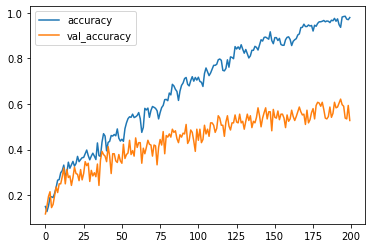

In [18]:
x_train, x_rest, y_train, y_rest = train_test_split(X, y, random_state=0, test_size=0.4)
x_test, x_val, y_test, y_val = train_test_split(x_rest,y_rest,random_state=0,test_size=0.5)
model = build(x_train)
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_val = np.expand_dims(x_val, axis=2)
        
history=model.fit(x_train, y_train, batch_size=100, epochs=200, validation_data=(x_val, y_val))
loss_history = pd.DataFrame(history.history)
loss_history[['accuracy','val_accuracy']].plot()

<h2> define function to compare accuracy between different features selection </h2>

In [19]:
def compared_paras():
    paras = ["stft","mfcc","mels","cqt","cens"]
    historys = []
    for para in paras:
        X,y = get_features([para],[])
        encoder = OneHotEncoder()
        y = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()
        x_train, x_rest, y_train, y_rest = train_test_split(X, y, random_state=0, test_size=0.4)
        x_test, x_val, y_test, y_val = train_test_split(x_rest,y_rest,random_state=0,test_size=0.5)
        model = build(x_train)
        #scaler = StandardScaler()
        #x_train = scaler.fit_transform(x_train)
        #x_test = scaler.transform(x_test)
        #x_val = scaler.transform(x_val)
        x_train = np.expand_dims(x_train, axis=2)
        x_test = np.expand_dims(x_test, axis=2)
        x_val = np.expand_dims(x_val, axis=2)
        
        history=model.fit(x_train, y_train, batch_size=16, epochs=100, validation_data=(x_val, y_val))
        historys.append(history)
        loss_history = pd.DataFrame(history.history)
        plt.plot(loss_history['val_accuracy'],label=para)
    plt.legend()
    plt.savefig("compared_paras_"+time.strftime("%Y%m%d-%H%M%S")+".png")
    plt.show()
    return historys

Epoch 1/100
54/54 [==============================] - 1s 6ms/step - loss: 2.0710 - accuracy: 0.1377 - val_loss: 2.0726 - val_accuracy: 0.1424
Epoch 2/100
54/54 [==============================] - 0s 4ms/step - loss: 2.0630 - accuracy: 0.1377 - val_loss: 2.0697 - val_accuracy: 0.1181
Epoch 3/100
54/54 [==============================] - 0s 4ms/step - loss: 2.0636 - accuracy: 0.1111 - val_loss: 2.0803 - val_accuracy: 0.1354
Epoch 4/100
54/54 [==============================] - 0s 4ms/step - loss: 2.0613 - accuracy: 0.1343 - val_loss: 2.0726 - val_accuracy: 0.1354
Epoch 5/100
54/54 [==============================] - 0s 4ms/step - loss: 2.0600 - accuracy: 0.1215 - val_loss: 2.0743 - val_accuracy: 0.1354
Epoch 6/100
54/54 [==============================] - 0s 4ms/step - loss: 2.0593 - accuracy: 0.1458 - val_loss: 2.0763 - val_accuracy: 0.1354
Epoch 7/100
54/54 [==============================] - 0s 4ms/step - loss: 2.0591 - accuracy: 0.1400 - val_loss: 2.0715 - val_accuracy: 0.1354
Epoch 8/100
5

Epoch 59/100
54/54 [==============================] - 0s 4ms/step - loss: 1.9519 - accuracy: 0.2049 - val_loss: 2.0020 - val_accuracy: 0.1806
Epoch 60/100
54/54 [==============================] - 0s 4ms/step - loss: 1.9478 - accuracy: 0.2014 - val_loss: 1.9950 - val_accuracy: 0.2014
Epoch 61/100
54/54 [==============================] - 0s 4ms/step - loss: 1.9441 - accuracy: 0.2280 - val_loss: 2.0099 - val_accuracy: 0.1875
Epoch 62/100
54/54 [==============================] - 0s 4ms/step - loss: 1.9396 - accuracy: 0.2188 - val_loss: 2.0006 - val_accuracy: 0.1806
Epoch 63/100
54/54 [==============================] - 0s 4ms/step - loss: 1.9480 - accuracy: 0.2049 - val_loss: 2.0049 - val_accuracy: 0.1875
Epoch 64/100
54/54 [==============================] - 0s 4ms/step - loss: 1.9426 - accuracy: 0.2141 - val_loss: 2.0105 - val_accuracy: 0.1840
Epoch 65/100
54/54 [==============================] - 0s 4ms/step - loss: 1.9444 - accuracy: 0.2072 - val_loss: 2.0189 - val_accuracy: 0.1875
Epoch 

Epoch 17/100
54/54 [==============================] - 0s 4ms/step - loss: 1.4241 - accuracy: 0.4861 - val_loss: 1.6278 - val_accuracy: 0.3854
Epoch 18/100
54/54 [==============================] - 0s 4ms/step - loss: 1.4199 - accuracy: 0.4907 - val_loss: 1.5656 - val_accuracy: 0.4340
Epoch 19/100
54/54 [==============================] - 0s 4ms/step - loss: 1.3101 - accuracy: 0.5428 - val_loss: 1.6246 - val_accuracy: 0.3854
Epoch 20/100
54/54 [==============================] - 0s 4ms/step - loss: 1.3428 - accuracy: 0.5012 - val_loss: 1.5760 - val_accuracy: 0.4340
Epoch 21/100
54/54 [==============================] - 0s 4ms/step - loss: 1.2652 - accuracy: 0.5440 - val_loss: 1.5917 - val_accuracy: 0.4479
Epoch 22/100
54/54 [==============================] - 0s 4ms/step - loss: 1.2091 - accuracy: 0.5694 - val_loss: 1.6769 - val_accuracy: 0.3854
Epoch 23/100
54/54 [==============================] - 0s 4ms/step - loss: 1.2056 - accuracy: 0.5718 - val_loss: 1.6118 - val_accuracy: 0.3958
Epoch 

Epoch 75/100
54/54 [==============================] - 0s 4ms/step - loss: 0.0846 - accuracy: 0.9884 - val_loss: 1.8896 - val_accuracy: 0.5625
Epoch 76/100
54/54 [==============================] - 0s 4ms/step - loss: 0.0704 - accuracy: 0.9919 - val_loss: 1.9378 - val_accuracy: 0.5451
Epoch 77/100
54/54 [==============================] - 0s 4ms/step - loss: 0.0751 - accuracy: 0.9907 - val_loss: 1.8354 - val_accuracy: 0.5347
Epoch 78/100
54/54 [==============================] - 0s 4ms/step - loss: 0.0948 - accuracy: 0.9838 - val_loss: 2.1381 - val_accuracy: 0.5104
Epoch 79/100
54/54 [==============================] - 0s 4ms/step - loss: 0.0950 - accuracy: 0.9769 - val_loss: 2.0245 - val_accuracy: 0.5347
Epoch 80/100
54/54 [==============================] - 0s 4ms/step - loss: 0.1574 - accuracy: 0.9525 - val_loss: 2.3288 - val_accuracy: 0.5174
Epoch 81/100
54/54 [==============================] - 0s 4ms/step - loss: 0.4374 - accuracy: 0.8553 - val_loss: 2.2244 - val_accuracy: 0.4722
Epoch 

Epoch 33/100
54/54 [==============================] - 0s 4ms/step - loss: 1.2367 - accuracy: 0.5451 - val_loss: 2.0070 - val_accuracy: 0.4167
Epoch 34/100
54/54 [==============================] - 0s 4ms/step - loss: 1.2250 - accuracy: 0.5764 - val_loss: 2.0817 - val_accuracy: 0.4236
Epoch 35/100
54/54 [==============================] - 0s 4ms/step - loss: 1.2120 - accuracy: 0.5752 - val_loss: 2.3570 - val_accuracy: 0.3993
Epoch 36/100
54/54 [==============================] - 0s 4ms/step - loss: 1.1872 - accuracy: 0.5671 - val_loss: 2.2050 - val_accuracy: 0.4062
Epoch 37/100
54/54 [==============================] - 0s 4ms/step - loss: 1.2011 - accuracy: 0.5637 - val_loss: 2.2541 - val_accuracy: 0.4062
Epoch 38/100
54/54 [==============================] - 0s 4ms/step - loss: 1.1715 - accuracy: 0.5752 - val_loss: 2.0633 - val_accuracy: 0.4062
Epoch 39/100
54/54 [==============================] - 0s 4ms/step - loss: 1.1340 - accuracy: 0.5810 - val_loss: 2.2989 - val_accuracy: 0.4271
Epoch 

Epoch 91/100
54/54 [==============================] - 0s 4ms/step - loss: 0.6842 - accuracy: 0.7616 - val_loss: 4.5352 - val_accuracy: 0.4618
Epoch 92/100
54/54 [==============================] - 0s 4ms/step - loss: 0.6875 - accuracy: 0.7627 - val_loss: 4.3842 - val_accuracy: 0.4132
Epoch 93/100
54/54 [==============================] - 0s 4ms/step - loss: 0.6777 - accuracy: 0.7558 - val_loss: 4.5198 - val_accuracy: 0.4549
Epoch 94/100
54/54 [==============================] - 0s 4ms/step - loss: 0.6916 - accuracy: 0.7674 - val_loss: 4.3680 - val_accuracy: 0.4444
Epoch 95/100
54/54 [==============================] - 0s 4ms/step - loss: 0.6641 - accuracy: 0.7755 - val_loss: 4.2014 - val_accuracy: 0.4514
Epoch 96/100
54/54 [==============================] - 0s 4ms/step - loss: 0.6436 - accuracy: 0.7778 - val_loss: 4.3158 - val_accuracy: 0.4271
Epoch 97/100
54/54 [==============================] - 0s 4ms/step - loss: 0.6321 - accuracy: 0.7755 - val_loss: 4.4107 - val_accuracy: 0.4514
Epoch 

C:\Users\15197\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=1012
  warnings.warn(


Epoch 1/100
54/54 [==============================] - 1s 7ms/step - loss: 2.0702 - accuracy: 0.1400 - val_loss: 2.0653 - val_accuracy: 0.1597
Epoch 2/100
54/54 [==============================] - 0s 4ms/step - loss: 2.0565 - accuracy: 0.1470 - val_loss: 2.0690 - val_accuracy: 0.1389
Epoch 3/100
54/54 [==============================] - 0s 4ms/step - loss: 2.0513 - accuracy: 0.1296 - val_loss: 2.0575 - val_accuracy: 0.1076
Epoch 4/100
54/54 [==============================] - 0s 4ms/step - loss: 2.0445 - accuracy: 0.1470 - val_loss: 2.0544 - val_accuracy: 0.1285
Epoch 5/100
54/54 [==============================] - 0s 4ms/step - loss: 2.0307 - accuracy: 0.1632 - val_loss: 2.0276 - val_accuracy: 0.2500
Epoch 6/100
54/54 [==============================] - 0s 4ms/step - loss: 2.0216 - accuracy: 0.1678 - val_loss: 2.0245 - val_accuracy: 0.2153
Epoch 7/100
54/54 [==============================] - 0s 4ms/step - loss: 2.0081 - accuracy: 0.1667 - val_loss: 2.0120 - val_accuracy: 0.1979
Epoch 8/100
5

Epoch 59/100
54/54 [==============================] - 0s 4ms/step - loss: 1.7076 - accuracy: 0.3380 - val_loss: 1.8821 - val_accuracy: 0.2882
Epoch 60/100
54/54 [==============================] - 0s 4ms/step - loss: 1.7336 - accuracy: 0.3391 - val_loss: 1.8862 - val_accuracy: 0.2778
Epoch 61/100
54/54 [==============================] - 0s 4ms/step - loss: 1.7195 - accuracy: 0.3241 - val_loss: 1.9211 - val_accuracy: 0.2639
Epoch 62/100
54/54 [==============================] - 0s 4ms/step - loss: 1.6972 - accuracy: 0.3368 - val_loss: 1.8762 - val_accuracy: 0.3090
Epoch 63/100
54/54 [==============================] - 0s 4ms/step - loss: 1.6785 - accuracy: 0.3553 - val_loss: 1.8945 - val_accuracy: 0.2986
Epoch 64/100
54/54 [==============================] - 0s 4ms/step - loss: 1.6896 - accuracy: 0.3449 - val_loss: 1.9162 - val_accuracy: 0.2639
Epoch 65/100
54/54 [==============================] - 0s 4ms/step - loss: 1.6936 - accuracy: 0.3553 - val_loss: 1.9340 - val_accuracy: 0.2639
Epoch 

C:\Users\15197\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=1012
  warnings.warn(


Epoch 1/100
54/54 [==============================] - 1s 7ms/step - loss: 2.0706 - accuracy: 0.1250 - val_loss: 2.0684 - val_accuracy: 0.1806
Epoch 2/100
54/54 [==============================] - 0s 4ms/step - loss: 2.0551 - accuracy: 0.1319 - val_loss: 2.0628 - val_accuracy: 0.1424
Epoch 3/100
54/54 [==============================] - 0s 4ms/step - loss: 2.0468 - accuracy: 0.1667 - val_loss: 2.0515 - val_accuracy: 0.2153
Epoch 4/100
54/54 [==============================] - 0s 4ms/step - loss: 2.0274 - accuracy: 0.1620 - val_loss: 2.0278 - val_accuracy: 0.2326
Epoch 5/100
54/54 [==============================] - 0s 4ms/step - loss: 2.0042 - accuracy: 0.1910 - val_loss: 2.0200 - val_accuracy: 0.1736
Epoch 6/100
54/54 [==============================] - 0s 4ms/step - loss: 1.9758 - accuracy: 0.2002 - val_loss: 1.9984 - val_accuracy: 0.2118
Epoch 7/100
54/54 [==============================] - 0s 4ms/step - loss: 1.9547 - accuracy: 0.2060 - val_loss: 1.9651 - val_accuracy: 0.2049
Epoch 8/100
5

Epoch 59/100
54/54 [==============================] - 0s 4ms/step - loss: 1.5916 - accuracy: 0.3877 - val_loss: 1.8691 - val_accuracy: 0.2812
Epoch 60/100
54/54 [==============================] - 0s 4ms/step - loss: 1.5981 - accuracy: 0.3738 - val_loss: 1.8880 - val_accuracy: 0.2326
Epoch 61/100
54/54 [==============================] - 0s 4ms/step - loss: 1.5852 - accuracy: 0.3785 - val_loss: 1.8953 - val_accuracy: 0.2535
Epoch 62/100
54/54 [==============================] - 0s 4ms/step - loss: 1.6269 - accuracy: 0.3623 - val_loss: 1.8798 - val_accuracy: 0.3021
Epoch 63/100
54/54 [==============================] - 0s 4ms/step - loss: 1.5844 - accuracy: 0.3785 - val_loss: 1.9066 - val_accuracy: 0.2743
Epoch 64/100
54/54 [==============================] - 0s 4ms/step - loss: 1.5645 - accuracy: 0.4005 - val_loss: 1.8781 - val_accuracy: 0.2847
Epoch 65/100
54/54 [==============================] - 0s 4ms/step - loss: 1.5514 - accuracy: 0.4097 - val_loss: 1.9235 - val_accuracy: 0.2674
Epoch 

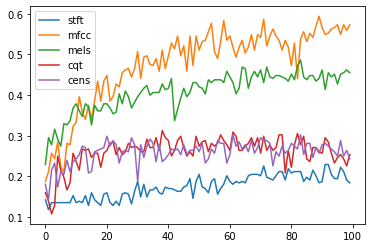

In [20]:
paras_historys = compared_paras()

In [21]:
def compared_multiple_paras():
    paras = ["mels","mfcc","cqt","cens","rms","zcr"]
    historys = []
    for i in range(len(paras)):
        para = paras[i]
        X,y = get_features(paras[:i+1],[])
        encoder = OneHotEncoder()
        y = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()
        x_train, x_rest, y_train, y_rest = train_test_split(X, y, random_state=0, test_size=0.4)
        x_test, x_val, y_test, y_val = train_test_split(x_rest,y_rest,random_state=0,test_size=0.5)
        model = build(x_train)
        x_train = np.expand_dims(x_train, axis=2)
        x_test = np.expand_dims(x_test, axis=2)
        x_val = np.expand_dims(x_val, axis=2)
        
        history=model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_val, y_val))
        historys.append(history)
        loss_history = pd.DataFrame(history.history)
        plt.plot(loss_history['val_accuracy'],label=paras[:i+1])
    plt.legend()
    plt.savefig("compared_multiple_paras_"+time.strftime("%Y%m%d-%H%M%S")+".png")
    plt.show()
    return historys

Epoch 1/100
14/14 [==============================] - 1s 20ms/step - loss: 2.0017 - accuracy: 0.1956 - val_loss: 1.9863 - val_accuracy: 0.1910
Epoch 2/100
14/14 [==============================] - 0s 9ms/step - loss: 1.8546 - accuracy: 0.2581 - val_loss: 1.8894 - val_accuracy: 0.2569
Epoch 3/100
14/14 [==============================] - 0s 9ms/step - loss: 1.7991 - accuracy: 0.2894 - val_loss: 1.9373 - val_accuracy: 0.2708
Epoch 4/100
14/14 [==============================] - 0s 9ms/step - loss: 1.8414 - accuracy: 0.2812 - val_loss: 1.9600 - val_accuracy: 0.2951
Epoch 5/100
14/14 [==============================] - 0s 9ms/step - loss: 1.7648 - accuracy: 0.3090 - val_loss: 1.8541 - val_accuracy: 0.3090
Epoch 6/100
14/14 [==============================] - 0s 9ms/step - loss: 1.7254 - accuracy: 0.3194 - val_loss: 1.7828 - val_accuracy: 0.3125
Epoch 7/100
14/14 [==============================] - 0s 9ms/step - loss: 1.6927 - accuracy: 0.3345 - val_loss: 1.8434 - val_accuracy: 0.3299
Epoch 8/100


Epoch 59/100
14/14 [==============================] - 0s 9ms/step - loss: 1.0936 - accuracy: 0.6100 - val_loss: 2.0838 - val_accuracy: 0.4271
Epoch 60/100
14/14 [==============================] - 0s 9ms/step - loss: 1.0782 - accuracy: 0.6053 - val_loss: 2.1890 - val_accuracy: 0.4271
Epoch 61/100
14/14 [==============================] - 0s 9ms/step - loss: 1.0703 - accuracy: 0.6215 - val_loss: 2.3816 - val_accuracy: 0.3924
Epoch 62/100
14/14 [==============================] - 0s 9ms/step - loss: 1.0711 - accuracy: 0.6007 - val_loss: 2.2910 - val_accuracy: 0.3889
Epoch 63/100
14/14 [==============================] - 0s 9ms/step - loss: 1.0689 - accuracy: 0.6030 - val_loss: 2.4446 - val_accuracy: 0.4271
Epoch 64/100
14/14 [==============================] - 0s 9ms/step - loss: 1.0395 - accuracy: 0.6238 - val_loss: 2.5151 - val_accuracy: 0.4236
Epoch 65/100
14/14 [==============================] - 0s 9ms/step - loss: 1.0204 - accuracy: 0.6319 - val_loss: 2.4961 - val_accuracy: 0.4201
Epoch 

Epoch 17/100
14/14 [==============================] - 0s 9ms/step - loss: 1.6838 - accuracy: 0.3426 - val_loss: 1.8262 - val_accuracy: 0.2986
Epoch 18/100
14/14 [==============================] - 0s 9ms/step - loss: 1.6474 - accuracy: 0.3588 - val_loss: 1.7535 - val_accuracy: 0.3194
Epoch 19/100
14/14 [==============================] - 0s 9ms/step - loss: 1.6281 - accuracy: 0.3877 - val_loss: 1.7390 - val_accuracy: 0.3229
Epoch 20/100
14/14 [==============================] - 0s 9ms/step - loss: 1.6365 - accuracy: 0.3727 - val_loss: 1.7423 - val_accuracy: 0.3889
Epoch 21/100
14/14 [==============================] - 0s 9ms/step - loss: 1.6064 - accuracy: 0.3808 - val_loss: 1.7692 - val_accuracy: 0.3472
Epoch 22/100
14/14 [==============================] - 0s 9ms/step - loss: 1.6038 - accuracy: 0.3843 - val_loss: 1.7890 - val_accuracy: 0.3507
Epoch 23/100
14/14 [==============================] - 0s 9ms/step - loss: 1.5661 - accuracy: 0.4282 - val_loss: 1.7675 - val_accuracy: 0.3333
Epoch 

Epoch 75/100
14/14 [==============================] - 0s 9ms/step - loss: 1.0842 - accuracy: 0.6192 - val_loss: 1.8878 - val_accuracy: 0.3993
Epoch 76/100
14/14 [==============================] - 0s 9ms/step - loss: 1.0872 - accuracy: 0.6053 - val_loss: 1.7342 - val_accuracy: 0.4444
Epoch 77/100
14/14 [==============================] - 0s 9ms/step - loss: 1.0433 - accuracy: 0.6146 - val_loss: 1.6789 - val_accuracy: 0.4340
Epoch 78/100
14/14 [==============================] - 0s 9ms/step - loss: 1.0211 - accuracy: 0.6447 - val_loss: 1.7819 - val_accuracy: 0.3924
Epoch 79/100
14/14 [==============================] - 0s 9ms/step - loss: 1.0170 - accuracy: 0.6331 - val_loss: 1.8312 - val_accuracy: 0.4340
Epoch 80/100
14/14 [==============================] - 0s 9ms/step - loss: 1.0292 - accuracy: 0.6215 - val_loss: 1.8984 - val_accuracy: 0.3715
Epoch 81/100
14/14 [==============================] - 0s 9ms/step - loss: 1.0141 - accuracy: 0.6227 - val_loss: 1.9018 - val_accuracy: 0.4306
Epoch 

C:\Users\15197\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=1012
  warnings.warn(


Epoch 1/100
14/14 [==============================] - 1s 21ms/step - loss: 41.2888 - accuracy: 0.1400 - val_loss: 20.5769 - val_accuracy: 0.1493
Epoch 2/100
14/14 [==============================] - 0s 10ms/step - loss: 9.0940 - accuracy: 0.1343 - val_loss: 2.9056 - val_accuracy: 0.1562
Epoch 3/100
14/14 [==============================] - 0s 10ms/step - loss: 2.2628 - accuracy: 0.2222 - val_loss: 2.1039 - val_accuracy: 0.1806
Epoch 4/100
14/14 [==============================] - 0s 9ms/step - loss: 1.8714 - accuracy: 0.2396 - val_loss: 1.8699 - val_accuracy: 0.2674
Epoch 5/100
14/14 [==============================] - 0s 10ms/step - loss: 1.8085 - accuracy: 0.2836 - val_loss: 1.8556 - val_accuracy: 0.2778
Epoch 6/100
14/14 [==============================] - 0s 9ms/step - loss: 1.7749 - accuracy: 0.3252 - val_loss: 1.8234 - val_accuracy: 0.2778
Epoch 7/100
14/14 [==============================] - 0s 9ms/step - loss: 1.7472 - accuracy: 0.3171 - val_loss: 1.8088 - val_accuracy: 0.2847
Epoch 8

C:\Users\15197\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=1012
  warnings.warn(


Epoch 1/100
14/14 [==============================] - 1s 22ms/step - loss: 42.2503 - accuracy: 0.1366 - val_loss: 17.6990 - val_accuracy: 0.1250
Epoch 2/100
14/14 [==============================] - 0s 11ms/step - loss: 6.9645 - accuracy: 0.1551 - val_loss: 2.5136 - val_accuracy: 0.1736
Epoch 3/100
14/14 [==============================] - 0s 10ms/step - loss: 2.1352 - accuracy: 0.2292 - val_loss: 1.9376 - val_accuracy: 0.2153
Epoch 4/100
14/14 [==============================] - 0s 10ms/step - loss: 1.8625 - accuracy: 0.2569 - val_loss: 1.9039 - val_accuracy: 0.2431
Epoch 5/100
14/14 [==============================] - 0s 10ms/step - loss: 1.8119 - accuracy: 0.2986 - val_loss: 1.8597 - val_accuracy: 0.2674
Epoch 6/100
14/14 [==============================] - 0s 10ms/step - loss: 1.7621 - accuracy: 0.2963 - val_loss: 1.8609 - val_accuracy: 0.2986
Epoch 7/100
14/14 [==============================] - 0s 10ms/step - loss: 1.7405 - accuracy: 0.3229 - val_loss: 1.8005 - val_accuracy: 0.3299
Epoc

C:\Users\15197\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=1012
  warnings.warn(


Epoch 1/100
14/14 [==============================] - 1s 24ms/step - loss: 51.1227 - accuracy: 0.1238 - val_loss: 12.1796 - val_accuracy: 0.1354
Epoch 2/100
14/14 [==============================] - 0s 11ms/step - loss: 5.3927 - accuracy: 0.1713 - val_loss: 2.2614 - val_accuracy: 0.1979
Epoch 3/100
14/14 [==============================] - 0s 10ms/step - loss: 2.0639 - accuracy: 0.2060 - val_loss: 2.0312 - val_accuracy: 0.1736
Epoch 4/100
14/14 [==============================] - 0s 10ms/step - loss: 1.8799 - accuracy: 0.2350 - val_loss: 1.9465 - val_accuracy: 0.2083
Epoch 5/100
14/14 [==============================] - 0s 10ms/step - loss: 1.8149 - accuracy: 0.2789 - val_loss: 1.8560 - val_accuracy: 0.2396
Epoch 6/100
14/14 [==============================] - 0s 10ms/step - loss: 1.7812 - accuracy: 0.2917 - val_loss: 1.8284 - val_accuracy: 0.2604
Epoch 7/100
14/14 [==============================] - 0s 10ms/step - loss: 1.7765 - accuracy: 0.2894 - val_loss: 1.7862 - val_accuracy: 0.3125
Epoc

C:\Users\15197\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=1012
  warnings.warn(


Epoch 1/100
14/14 [==============================] - 1s 21ms/step - loss: 42.9406 - accuracy: 0.1273 - val_loss: 12.1629 - val_accuracy: 0.1562
Epoch 2/100
14/14 [==============================] - 0s 11ms/step - loss: 4.7573 - accuracy: 0.1875 - val_loss: 2.2951 - val_accuracy: 0.1944
Epoch 3/100
14/14 [==============================] - 0s 11ms/step - loss: 2.0449 - accuracy: 0.2199 - val_loss: 1.9616 - val_accuracy: 0.2500
Epoch 4/100
14/14 [==============================] - 0s 10ms/step - loss: 1.8377 - accuracy: 0.2731 - val_loss: 1.9023 - val_accuracy: 0.2361
Epoch 5/100
14/14 [==============================] - 0s 10ms/step - loss: 1.8027 - accuracy: 0.2928 - val_loss: 1.8215 - val_accuracy: 0.3056
Epoch 6/100
14/14 [==============================] - 0s 10ms/step - loss: 1.7815 - accuracy: 0.3021 - val_loss: 1.8553 - val_accuracy: 0.2743
Epoch 7/100
14/14 [==============================] - 0s 11ms/step - loss: 1.7593 - accuracy: 0.3194 - val_loss: 1.8148 - val_accuracy: 0.3160
Epoc

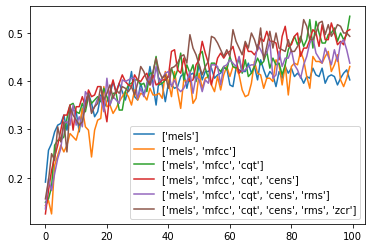

In [22]:
compared_multiple_paras()

<h2> compare the accuracy between different data augmentation </h2>

In [23]:
def compared_augs():
    paras = ["noise","time_shift","time_stretch","pitch_shift"]
    historys = []
    for i in range(len(paras)):
        para = paras[i]
        X,y = get_features(["mels","mfcc"],paras[:i+1])
        encoder = OneHotEncoder()
        y = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()
        x_train, x_rest, y_train, y_rest = train_test_split(X, y, random_state=0, test_size=0.4)
        x_test, x_val, y_test, y_val = train_test_split(x_rest,y_rest,random_state=0,test_size=0.5)
        model = build(x_train)
        x_train = np.expand_dims(x_train, axis=2)
        x_test = np.expand_dims(x_test, axis=2)
        x_val = np.expand_dims(x_val, axis=2)
        
        history=model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_val, y_val))
        historys.append(history)
        loss_history = pd.DataFrame(history.history)
        plt.plot(loss_history['val_accuracy'],label=paras[:i+1])
    plt.legend()
    plt.savefig("compared_multiple_augs_"+time.strftime("%Y%m%d-%H%M%S")+".png")
    plt.show()
    return historys

In [39]:
X,y = get_features(["mfcc","mels"],["noise","time_shift"])


In [40]:
info = pd.DataFrame(X)
info.shape

(4320, 148)

Epoch 1/100
27/27 [==============================] - 1s 16ms/step - loss: 17.4613 - accuracy: 0.1626 - val_loss: 2.2737 - val_accuracy: 0.2500
Epoch 2/100
27/27 [==============================] - 0s 9ms/step - loss: 1.9476 - accuracy: 0.2234 - val_loss: 1.7941 - val_accuracy: 0.2969
Epoch 3/100
27/27 [==============================] - 0s 9ms/step - loss: 1.7887 - accuracy: 0.3073 - val_loss: 1.7504 - val_accuracy: 0.2812
Epoch 4/100
27/27 [==============================] - 0s 9ms/step - loss: 1.7433 - accuracy: 0.3032 - val_loss: 1.7547 - val_accuracy: 0.3073
Epoch 5/100
27/27 [==============================] - 0s 9ms/step - loss: 1.7158 - accuracy: 0.3374 - val_loss: 1.7608 - val_accuracy: 0.3663
Epoch 6/100
27/27 [==============================] - 0s 9ms/step - loss: 1.6963 - accuracy: 0.3362 - val_loss: 1.7736 - val_accuracy: 0.3507
Epoch 7/100
27/27 [==============================] - 0s 9ms/step - loss: 1.6775 - accuracy: 0.3524 - val_loss: 1.7152 - val_accuracy: 0.3663
Epoch 8/100

Epoch 59/100
27/27 [==============================] - 0s 9ms/step - loss: 1.0732 - accuracy: 0.6100 - val_loss: 1.7386 - val_accuracy: 0.5278
Epoch 60/100
27/27 [==============================] - 0s 8ms/step - loss: 1.0577 - accuracy: 0.6134 - val_loss: 1.9701 - val_accuracy: 0.5122
Epoch 61/100
27/27 [==============================] - 0s 9ms/step - loss: 1.0350 - accuracy: 0.6204 - val_loss: 1.8240 - val_accuracy: 0.5069
Epoch 62/100
27/27 [==============================] - 0s 8ms/step - loss: 1.0301 - accuracy: 0.6175 - val_loss: 1.7620 - val_accuracy: 0.5330
Epoch 63/100
27/27 [==============================] - 0s 8ms/step - loss: 1.0251 - accuracy: 0.6291 - val_loss: 1.7048 - val_accuracy: 0.5139
Epoch 64/100
27/27 [==============================] - 0s 8ms/step - loss: 0.9886 - accuracy: 0.6383 - val_loss: 1.8632 - val_accuracy: 0.5278
Epoch 65/100
27/27 [==============================] - 0s 8ms/step - loss: 0.9589 - accuracy: 0.6458 - val_loss: 1.8845 - val_accuracy: 0.5330
Epoch 

Epoch 17/100
41/41 [==============================] - 0s 8ms/step - loss: 1.4499 - accuracy: 0.4772 - val_loss: 1.4382 - val_accuracy: 0.4745
Epoch 18/100
41/41 [==============================] - 0s 8ms/step - loss: 1.4405 - accuracy: 0.4753 - val_loss: 1.5083 - val_accuracy: 0.4259
Epoch 19/100
41/41 [==============================] - 0s 8ms/step - loss: 1.4374 - accuracy: 0.4753 - val_loss: 1.4444 - val_accuracy: 0.4780
Epoch 20/100
41/41 [==============================] - 0s 8ms/step - loss: 1.4046 - accuracy: 0.4880 - val_loss: 1.4290 - val_accuracy: 0.4688
Epoch 21/100
41/41 [==============================] - 0s 8ms/step - loss: 1.3690 - accuracy: 0.5039 - val_loss: 1.4537 - val_accuracy: 0.4444
Epoch 22/100
41/41 [==============================] - 0s 8ms/step - loss: 1.3570 - accuracy: 0.5008 - val_loss: 1.3994 - val_accuracy: 0.4757
Epoch 23/100
41/41 [==============================] - 0s 8ms/step - loss: 1.3227 - accuracy: 0.5243 - val_loss: 1.3639 - val_accuracy: 0.5081
Epoch 

Epoch 75/100
41/41 [==============================] - 0s 8ms/step - loss: 0.6864 - accuracy: 0.7508 - val_loss: 0.8691 - val_accuracy: 0.6968
Epoch 76/100
41/41 [==============================] - 0s 8ms/step - loss: 0.6422 - accuracy: 0.7751 - val_loss: 0.9006 - val_accuracy: 0.6782
Epoch 77/100
41/41 [==============================] - 0s 8ms/step - loss: 0.6374 - accuracy: 0.7724 - val_loss: 0.8554 - val_accuracy: 0.7083
Epoch 78/100
41/41 [==============================] - 0s 8ms/step - loss: 0.6202 - accuracy: 0.7778 - val_loss: 0.8799 - val_accuracy: 0.7002
Epoch 79/100
41/41 [==============================] - 0s 8ms/step - loss: 0.5892 - accuracy: 0.7955 - val_loss: 0.8518 - val_accuracy: 0.7188
Epoch 80/100
41/41 [==============================] - 0s 8ms/step - loss: 0.6063 - accuracy: 0.7874 - val_loss: 0.8855 - val_accuracy: 0.7083
Epoch 81/100
41/41 [==============================] - 0s 8ms/step - loss: 0.6609 - accuracy: 0.7689 - val_loss: 0.9941 - val_accuracy: 0.6817
Epoch 

Epoch 33/100
54/54 [==============================] - 0s 8ms/step - loss: 1.0411 - accuracy: 0.6157 - val_loss: 1.1532 - val_accuracy: 0.5781
Epoch 34/100
54/54 [==============================] - 0s 8ms/step - loss: 1.0430 - accuracy: 0.6218 - val_loss: 1.1118 - val_accuracy: 0.6050
Epoch 35/100
54/54 [==============================] - 0s 8ms/step - loss: 0.9997 - accuracy: 0.6354 - val_loss: 1.0960 - val_accuracy: 0.6137
Epoch 36/100
54/54 [==============================] - 0s 8ms/step - loss: 0.9824 - accuracy: 0.6383 - val_loss: 1.1252 - val_accuracy: 0.5825
Epoch 37/100
54/54 [==============================] - 0s 8ms/step - loss: 0.9639 - accuracy: 0.6522 - val_loss: 1.0329 - val_accuracy: 0.6128
Epoch 38/100
54/54 [==============================] - 0s 8ms/step - loss: 0.9362 - accuracy: 0.6580 - val_loss: 1.0792 - val_accuracy: 0.6059
Epoch 39/100
54/54 [==============================] - 0s 8ms/step - loss: 0.9420 - accuracy: 0.6571 - val_loss: 1.0150 - val_accuracy: 0.6337
Epoch 

Epoch 91/100
54/54 [==============================] - 0s 8ms/step - loss: 0.2900 - accuracy: 0.9141 - val_loss: 0.6234 - val_accuracy: 0.8038
Epoch 92/100
54/54 [==============================] - 0s 8ms/step - loss: 0.3075 - accuracy: 0.9010 - val_loss: 0.7057 - val_accuracy: 0.7734
Epoch 93/100
54/54 [==============================] - 0s 8ms/step - loss: 0.2812 - accuracy: 0.9094 - val_loss: 0.6840 - val_accuracy: 0.7925
Epoch 94/100
54/54 [==============================] - 0s 8ms/step - loss: 0.2808 - accuracy: 0.9155 - val_loss: 0.7634 - val_accuracy: 0.7726
Epoch 95/100
54/54 [==============================] - 0s 8ms/step - loss: 0.4573 - accuracy: 0.8449 - val_loss: 0.8909 - val_accuracy: 0.7387
Epoch 96/100
54/54 [==============================] - 0s 8ms/step - loss: 0.3890 - accuracy: 0.8652 - val_loss: 0.8019 - val_accuracy: 0.7622
Epoch 97/100
54/54 [==============================] - 0s 8ms/step - loss: 0.3366 - accuracy: 0.8895 - val_loss: 0.7179 - val_accuracy: 0.7726
Epoch 

Epoch 49/100
68/68 [==============================] - 1s 8ms/step - loss: 0.8874 - accuracy: 0.6817 - val_loss: 1.0914 - val_accuracy: 0.6007
Epoch 50/100
68/68 [==============================] - 1s 8ms/step - loss: 0.8775 - accuracy: 0.6810 - val_loss: 1.1475 - val_accuracy: 0.6222
Epoch 51/100
68/68 [==============================] - 1s 8ms/step - loss: 0.8739 - accuracy: 0.6854 - val_loss: 1.1128 - val_accuracy: 0.6187
Epoch 52/100
68/68 [==============================] - 1s 8ms/step - loss: 0.8306 - accuracy: 0.7072 - val_loss: 1.1495 - val_accuracy: 0.5917
Epoch 53/100
68/68 [==============================] - 1s 8ms/step - loss: 0.8473 - accuracy: 0.7023 - val_loss: 1.2337 - val_accuracy: 0.6035
Epoch 54/100
68/68 [==============================] - 1s 8ms/step - loss: 0.8087 - accuracy: 0.7153 - val_loss: 1.1519 - val_accuracy: 0.6167
Epoch 55/100
68/68 [==============================] - 1s 8ms/step - loss: 0.7956 - accuracy: 0.7130 - val_loss: 1.2070 - val_accuracy: 0.6118
Epoch 

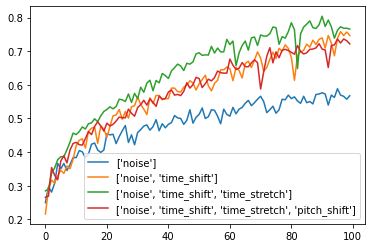

In [24]:
compared_augs()

<h2> compare accuracy between decay rate </h2>

In [25]:
def build_model_with_decay(x_train,initial_rate,decay_step, decay_rate):
    model=Sequential()
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(pd.DataFrame(x_train).shape[1], 1)))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Flatten())
    model.add(Dense(8))
    model.add(Activation('softmax'))
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_rate,
    decay_steps=decay_step,
    decay_rate=decay_rate,
    staircase=True)


    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr_schedule), metrics=['accuracy'])

    return model

In [26]:
def compared_decay_rate():
    initials = [0.001,0.0001]
    steps = [10000,100000]
    rates = [0.96]
    historys =[]
    for initial in initials:
        for step in steps:
            for rate in rates:
                X,y = get_features(["mels"],["noise","time_shift","time_stretch","pitch_shift"])
                encoder = OneHotEncoder()
                y = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()
                x_train, x_rest, y_train, y_rest = train_test_split(X, y, random_state=0, test_size=0.4)
                x_test, x_val, y_test, y_val = train_test_split(x_rest,y_rest,random_state=0,test_size=0.5)
                model = build_model_with_decay(x_train,initial,step,rate)
                x_train = np.expand_dims(x_train, axis=2)
                x_test = np.expand_dims(x_test, axis=2)
                x_val = np.expand_dims(x_val, axis=2)
        
                history=model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_val, y_val),callbacks=callback_list)
                historys.append(history)
                loss_history = pd.DataFrame(history.history)
                plt.plot(loss_history['val_accuracy'],label="initial: "+str(initial)+ " steps: "+str(step)+ " rate: "+str(rate))
    plt.legend()
    plt.show()
    plt.savefig("compared_decay_rate_"+time.strftime("%Y%m%d-%H%M%S")+".png")
    return historys
                

Epoch 1/100
66/68 [============================>.] - ETA: 0s - loss: 1.9041 - accuracy: 0.2429
Epoch 00001: val_accuracy improved from -inf to 0.27778, saving model to saved_models\weight-model-improvement-01-0.28-20211202-114244.h5
68/68 [==============================] - 1s 13ms/step - loss: 1.9047 - accuracy: 0.2442 - val_loss: 1.7995 - val_accuracy: 0.2778
Epoch 2/100
64/68 [===========================>..] - ETA: 0s - loss: 1.7643 - accuracy: 0.3062
Epoch 00002: val_accuracy improved from 0.27778 to 0.34028, saving model to saved_models\weight-model-improvement-02-0.34-20211202-114244.h5
68/68 [==============================] - 1s 9ms/step - loss: 1.7625 - accuracy: 0.3083 - val_loss: 1.7215 - val_accuracy: 0.3403
Epoch 3/100
65/68 [===========================>..] - ETA: 0s - loss: 1.7355 - accuracy: 0.3202
Epoch 00003: val_accuracy improved from 0.34028 to 0.36597, saving model to saved_models\weight-model-improvement-03-0.37-20211202-114244.h5
68/68 [=============================

Epoch 25/100
65/68 [===========================>..] - ETA: 0s - loss: 1.2120 - accuracy: 0.5663
Epoch 00025: val_accuracy improved from 0.52986 to 0.55347, saving model to saved_models\weight-model-improvement-25-0.55-20211202-114244.h5
68/68 [==============================] - 1s 8ms/step - loss: 1.2085 - accuracy: 0.5662 - val_loss: 1.4090 - val_accuracy: 0.5535
Epoch 26/100
65/68 [===========================>..] - ETA: 0s - loss: 1.1847 - accuracy: 0.5724
Epoch 00026: val_accuracy did not improve from 0.55347
68/68 [==============================] - 1s 8ms/step - loss: 1.1909 - accuracy: 0.5697 - val_loss: 1.4065 - val_accuracy: 0.5292
Epoch 27/100
65/68 [===========================>..] - ETA: 0s - loss: 1.1927 - accuracy: 0.5620
Epoch 00027: val_accuracy did not improve from 0.55347
68/68 [==============================] - 1s 8ms/step - loss: 1.1897 - accuracy: 0.5646 - val_loss: 1.3980 - val_accuracy: 0.5458
Epoch 28/100
65/68 [===========================>..] - ETA: 0s - loss: 1.15

65/68 [===========================>..] - ETA: 0s - loss: 1.3461 - accuracy: 0.5012
Epoch 00017: val_accuracy did not improve from 0.63125
68/68 [==============================] - 1s 8ms/step - loss: 1.3452 - accuracy: 0.5023 - val_loss: 1.4150 - val_accuracy: 0.4833
Epoch 18/100
65/68 [===========================>..] - ETA: 0s - loss: 1.3225 - accuracy: 0.5123
Epoch 00018: val_accuracy did not improve from 0.63125
68/68 [==============================] - 1s 8ms/step - loss: 1.3195 - accuracy: 0.5118 - val_loss: 1.4579 - val_accuracy: 0.5090
Epoch 19/100
65/68 [===========================>..] - ETA: 0s - loss: 1.3410 - accuracy: 0.5144
Epoch 00019: val_accuracy did not improve from 0.63125
68/68 [==============================] - 1s 8ms/step - loss: 1.3457 - accuracy: 0.5125 - val_loss: 1.4760 - val_accuracy: 0.4576
Epoch 20/100
65/68 [===========================>..] - ETA: 0s - loss: 1.3743 - accuracy: 0.4998
Epoch 00020: val_accuracy did not improve from 0.63125
68/68 [===============

Epoch 12/100
65/68 [===========================>..] - ETA: 0s - loss: 1.6915 - accuracy: 0.3452
Epoch 00012: val_accuracy did not improve from 0.65347
68/68 [==============================] - 1s 8ms/step - loss: 1.6908 - accuracy: 0.3470 - val_loss: 1.6878 - val_accuracy: 0.3611
Epoch 13/100
65/68 [===========================>..] - ETA: 0s - loss: 1.6849 - accuracy: 0.3507
Epoch 00013: val_accuracy did not improve from 0.65347
68/68 [==============================] - 1s 8ms/step - loss: 1.6848 - accuracy: 0.3514 - val_loss: 1.6941 - val_accuracy: 0.3514
Epoch 14/100
65/68 [===========================>..] - ETA: 0s - loss: 1.6807 - accuracy: 0.3481
Epoch 00014: val_accuracy did not improve from 0.65347
68/68 [==============================] - 1s 8ms/step - loss: 1.6799 - accuracy: 0.3486 - val_loss: 1.6687 - val_accuracy: 0.3778
Epoch 15/100
65/68 [===========================>..] - ETA: 0s - loss: 1.6684 - accuracy: 0.3661
Epoch 00015: val_accuracy did not improve from 0.65347
68/68 [==

65/68 [===========================>..] - ETA: 0s - loss: 1.3925 - accuracy: 0.4733
Epoch 00070: val_accuracy did not improve from 0.65347
68/68 [==============================] - 1s 8ms/step - loss: 1.3938 - accuracy: 0.4738 - val_loss: 1.5508 - val_accuracy: 0.4549
Epoch 71/100
65/68 [===========================>..] - ETA: 0s - loss: 1.3899 - accuracy: 0.4779
Epoch 00071: val_accuracy did not improve from 0.65347
Restoring model weights from the end of the best epoch: 51.
68/68 [==============================] - 1s 8ms/step - loss: 1.3913 - accuracy: 0.4792 - val_loss: 1.5596 - val_accuracy: 0.4625
Epoch 00071: early stopping
Epoch 1/100
64/68 [===========================>..] - ETA: 0s - loss: 1.9557 - accuracy: 0.1760
Epoch 00001: val_accuracy did not improve from 0.65347
68/68 [==============================] - 1s 11ms/step - loss: 1.9532 - accuracy: 0.1782 - val_loss: 1.8917 - val_accuracy: 0.2764
Epoch 2/100
65/68 [===========================>..] - ETA: 0s - loss: 1.8714 - accurac

65/68 [===========================>..] - ETA: 0s - loss: 1.5764 - accuracy: 0.3964
Epoch 00028: val_accuracy did not improve from 0.65347
68/68 [==============================] - 1s 8ms/step - loss: 1.5784 - accuracy: 0.3972 - val_loss: 1.6003 - val_accuracy: 0.3944
Epoch 29/100
65/68 [===========================>..] - ETA: 0s - loss: 1.5726 - accuracy: 0.3981
Epoch 00029: val_accuracy did not improve from 0.65347
68/68 [==============================] - 1s 8ms/step - loss: 1.5720 - accuracy: 0.3981 - val_loss: 1.6234 - val_accuracy: 0.3951
Epoch 30/100
65/68 [===========================>..] - ETA: 0s - loss: 1.5713 - accuracy: 0.4038
Epoch 00030: val_accuracy did not improve from 0.65347
68/68 [==============================] - 1s 8ms/step - loss: 1.5683 - accuracy: 0.4035 - val_loss: 1.5684 - val_accuracy: 0.4118
Epoch 31/100
65/68 [===========================>..] - ETA: 0s - loss: 1.5524 - accuracy: 0.4055
Epoch 00031: val_accuracy did not improve from 0.65347
68/68 [===============

65/68 [===========================>..] - ETA: 0s - loss: 1.3550 - accuracy: 0.5002 ETA: 0s - loss: 1.3426 - accuracy: 
Epoch 00086: val_accuracy did not improve from 0.65347
68/68 [==============================] - 1s 8ms/step - loss: 1.3541 - accuracy: 0.5005 - val_loss: 1.4624 - val_accuracy: 0.4771
Epoch 87/100
65/68 [===========================>..] - ETA: 0s - loss: 1.3397 - accuracy: 0.5010
Epoch 00087: val_accuracy did not improve from 0.65347
68/68 [==============================] - 1s 8ms/step - loss: 1.3420 - accuracy: 0.5023 - val_loss: 1.4745 - val_accuracy: 0.4785
Epoch 88/100
65/68 [===========================>..] - ETA: 0s - loss: 1.3343 - accuracy: 0.5058
Epoch 00088: val_accuracy did not improve from 0.65347
Restoring model weights from the end of the best epoch: 68.
68/68 [==============================] - 1s 8ms/step - loss: 1.3327 - accuracy: 0.5063 - val_loss: 1.4924 - val_accuracy: 0.4743
Epoch 00088: early stopping


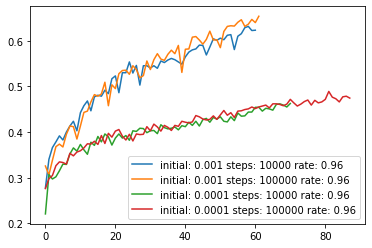

<Figure size 432x288 with 0 Axes>

In [27]:
decay_rate_historys = compared_decay_rate()

<h2> compare accuracy between decay and reduction </h2>

In [28]:
def compared_decay_reduction():
    historys =[]
    X,y = get_features(["mels"],["noise","time_shift","time_stretch","pitch_shift"])
    encoder = OneHotEncoder()
    y = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()
    x_train, x_rest, y_train, y_rest = train_test_split(X, y, random_state=0, test_size=0.4)
    x_test, x_val, y_test, y_val = train_test_split(x_rest,y_rest,random_state=0,test_size=0.5)
    decay_model = build_model_with_decay(x_train,0.001,100000,0.96)
    reduction_model = build(x_train)
    x_train = np.expand_dims(x_train, axis=2)
    x_test = np.expand_dims(x_test, axis=2)
    x_val = np.expand_dims(x_val, axis=2)
        
    decay_history=decay_model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_val, y_val),callbacks=callback_list)
    reduction_history=reduction_model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_val, y_val),callbacks=callback_list_with_reduction)
    historys = [decay_history, reduction_history]
    decay_loss_history = pd.DataFrame(decay_history.history)
    reduction_loss_history = pd.DataFrame(reduction_history.history)
    plt.plot(decay_loss_history['val_accuracy'],label="decay")
    plt.plot(reduction_loss_history["val_accuracy"],label="reduction")
    plt.legend()
    plt.show()
    plt.savefig("compared_decay_reduction_"+time.strftime("%Y%m%d-%H%M%S")+".png")
    return historys

Epoch 1/100
63/68 [==========================>...] - ETA: 0s - loss: 1.9009 - accuracy: 0.2438
Epoch 00001: val_accuracy did not improve from 0.65347
68/68 [==============================] - 1s 12ms/step - loss: 1.8942 - accuracy: 0.2470 - val_loss: 1.8280 - val_accuracy: 0.2840
Epoch 2/100
65/68 [===========================>..] - ETA: 0s - loss: 1.7768 - accuracy: 0.3000
Epoch 00002: val_accuracy did not improve from 0.65347
68/68 [==============================] - 1s 8ms/step - loss: 1.7768 - accuracy: 0.3005 - val_loss: 1.7717 - val_accuracy: 0.3375
Epoch 3/100
65/68 [===========================>..] - ETA: 0s - loss: 1.7316 - accuracy: 0.3226
Epoch 00003: val_accuracy did not improve from 0.65347
68/68 [==============================] - 1s 8ms/step - loss: 1.7325 - accuracy: 0.3227 - val_loss: 1.6964 - val_accuracy: 0.3479
Epoch 4/100
65/68 [===========================>..] - ETA: 0s - loss: 1.7057 - accuracy: 0.3341
Epoch 00004: val_accuracy did not improve from 0.65347
68/68 [=====

Epoch 5/100
65/68 [===========================>..] - ETA: 0s - loss: 1.6723 - accuracy: 0.3587
Epoch 00005: val_accuracy did not improve from 0.65347
68/68 [==============================] - 1s 8ms/step - loss: 1.6734 - accuracy: 0.3562 - val_loss: 1.6165 - val_accuracy: 0.3847 - lr: 0.0010
Epoch 6/100
65/68 [===========================>..] - ETA: 0s - loss: 1.6155 - accuracy: 0.3812
Epoch 00006: val_accuracy did not improve from 0.65347
68/68 [==============================] - 1s 8ms/step - loss: 1.6207 - accuracy: 0.3799 - val_loss: 1.5754 - val_accuracy: 0.3903 - lr: 0.0010
Epoch 7/100
65/68 [===========================>..] - ETA: 0s - loss: 1.5881 - accuracy: 0.3897
Epoch 00007: val_accuracy did not improve from 0.65347
68/68 [==============================] - 1s 8ms/step - loss: 1.5879 - accuracy: 0.3896 - val_loss: 1.5555 - val_accuracy: 0.4035 - lr: 0.0010
Epoch 8/100
65/68 [===========================>..] - ETA: 0s - loss: 1.5561 - accuracy: 0.4062
Epoch 00008: val_accuracy did

Epoch 33/100
65/68 [===========================>..] - ETA: 0s - loss: 1.0349 - accuracy: 0.6322
Epoch 00033: val_accuracy did not improve from 0.65347
68/68 [==============================] - 1s 8ms/step - loss: 1.0316 - accuracy: 0.6331 - val_loss: 1.2317 - val_accuracy: 0.5694 - lr: 1.0000e-04
Epoch 34/100
65/68 [===========================>..] - ETA: 0s - loss: 1.0174 - accuracy: 0.6377
Epoch 00034: val_accuracy did not improve from 0.65347
68/68 [==============================] - 1s 8ms/step - loss: 1.0212 - accuracy: 0.6359 - val_loss: 1.2298 - val_accuracy: 0.5708 - lr: 1.0000e-04
Epoch 35/100
65/68 [===========================>..] - ETA: 0s - loss: 1.0192 - accuracy: 0.6373
Epoch 00035: val_accuracy did not improve from 0.65347
68/68 [==============================] - 1s 8ms/step - loss: 1.0176 - accuracy: 0.6370 - val_loss: 1.2247 - val_accuracy: 0.5701 - lr: 1.0000e-04
Epoch 36/100
65/68 [===========================>..] - ETA: 0s - loss: 1.0167 - accuracy: 0.6387
Epoch 00036: 

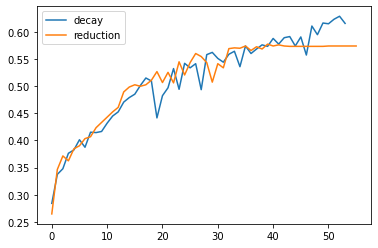

<Figure size 432x288 with 0 Axes>

In [29]:
decay_reduction_historys = compared_decay_reduction()

# trying different model architecture

In [17]:
X,y = get_features(["mfcc","mels","cqt"],["noise","time_shift","time_stretch","pitch_shift"])
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()
x_train, x_rest, y_train, y_rest = train_test_split(X, y, random_state=0, test_size=0.4)
x_test, x_val, y_test, y_val = train_test_split(x_rest,y_rest,random_state=0,test_size=0.5)
shape = pd.DataFrame(x_train).shape[1]

x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_val = np.expand_dims(x_val, axis=2)

C:\Users\15197\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=1012
  warnings.warn(


In [18]:
def train_model(build_model):
    model = build_model(shape)
    history=model.fit(x_train, y_train, batch_size=100, epochs=150, validation_data=(x_val, y_val),callbacks=callback_list_with_reduction)
    return history, model

<h2> model 1 </h2><br/>
three convolution; two maxpooling, two dense

In [16]:
def build_model1(shape):
    model=Sequential()
    model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(shape, 1)))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(Flatten())
    model.add(Dense(256,activation="relu"))
    model.add(Dense(128,activation="relu"))
    model.add(Dense(8))
    model.add(Activation('softmax'))


    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [17]:
history1, model1 = train_model(build_model1)




Epoch 1/500
44/44 [==============================] - ETA: 0s - loss: 2.7447 - accuracy: 0.1870
Epoch 00001: val_accuracy improved from -inf to 0.27083, saving model to saved_models\weight-model-improvement-01-0.27-20211129-155847.h5
44/44 [==============================] - 4s 21ms/step - loss: 2.7447 - accuracy: 0.1870 - val_loss: 1.8876 - val_accuracy: 0.2708 - lr: 0.0010
Epoch 2/500
43/44 [============================>.] - ETA: 0s - loss: 1.8254 - accuracy: 0.2751
Epoch 00002: val_accuracy improved from 0.27083 to 0.32083, saving model to saved_models\weight-model-improvement-02-0.32-20211129-155847.h5
44/44 [==============================] - 0s 10ms/step - loss: 1.8227 - accuracy: 0.2762 - val_loss: 1.7224 - val_accuracy: 0.3208 - lr: 0.0010
Epoch 3/500
43/44 [============================>.] - ETA: 0s - loss: 1.7395 - accuracy: 0.3151 ETA: 0s - loss: 1.7566 - accura
Epoch 00003: val_accuracy improved from 0.32083 to 0.32292, saving model to saved_models\weight-model-improvement-03-0

44/44 [==============================] - 0s 10ms/step - loss: 0.5171 - accuracy: 0.8248 - val_loss: 0.9283 - val_accuracy: 0.6896 - lr: 0.0010
Epoch 24/500
43/44 [============================>.] - ETA: 0s - loss: 0.5011 - accuracy: 0.8163
Epoch 00024: val_accuracy improved from 0.68958 to 0.69722, saving model to saved_models\weight-model-improvement-24-0.70-20211129-155847.h5
44/44 [==============================] - 0s 10ms/step - loss: 0.5014 - accuracy: 0.8164 - val_loss: 0.8990 - val_accuracy: 0.6972 - lr: 0.0010
Epoch 25/500
43/44 [============================>.] - ETA: 0s - loss: 0.4901 - accuracy: 0.8270
Epoch 00025: val_accuracy improved from 0.69722 to 0.71458, saving model to saved_models\weight-model-improvement-25-0.71-20211129-155847.h5
44/44 [==============================] - 0s 10ms/step - loss: 0.4899 - accuracy: 0.8273 - val_loss: 0.8678 - val_accuracy: 0.7146 - lr: 0.0010
Epoch 26/500
43/44 [============================>.] - ETA: 0s - loss: 0.4535 - accuracy: 0.8430
E

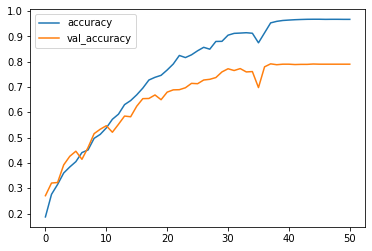

In [18]:
loss_history1 = pd.DataFrame(history1.history)
plt.plot(loss_history1["accuracy"],label="accuracy")
plt.plot(loss_history1["val_accuracy"],label="val_accuracy")
plt.legend()
plt.savefig("model1_acc.png")
plt.show()


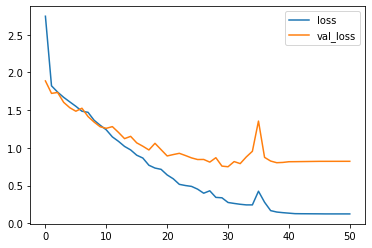

In [19]:
plt.plot(loss_history1["loss"],label="loss")
plt.plot(loss_history1["val_loss"],label="val_loss")
plt.legend()
plt.savefig("model1_loss.png")
plt.show()


In [20]:
model1.save('model1.h5')

In [29]:
model1 = tf.keras.models.load_model("model1.h5")

<h2> model 2 </h2> <br />
4 convulution, 4 maxpooling, three dense

In [51]:
def build_model2(shape):
    model=Sequential()
    model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(shape, 1)))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(Flatten())
    model.add(Dense(256,activation="relu"))
    model.add(Dense(128,activation="relu"))
    model.add(Dense(8))
    model.add(Activation('softmax'))


    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [52]:
history2, model2 = train_model(build_model2)
loss_history2 = pd.DataFrame(history2.history)

Epoch 1/500
43/44 [============================>.] - ETA: 0s - loss: 3.0239 - accuracy: 0.1928
Epoch 00001: val_accuracy did not improve from 0.79167
44/44 [==============================] - 1s 18ms/step - loss: 3.0176 - accuracy: 0.1937 - val_loss: 1.8572 - val_accuracy: 0.2514 - lr: 0.0010
Epoch 2/500
42/44 [===========================>..] - ETA: 0s - loss: 1.8325 - accuracy: 0.2762
Epoch 00002: val_accuracy did not improve from 0.79167
44/44 [==============================] - 0s 11ms/step - loss: 1.8324 - accuracy: 0.2757 - val_loss: 1.9527 - val_accuracy: 0.2222 - lr: 0.0010
Epoch 3/500
43/44 [============================>.] - ETA: 0s - loss: 1.7752 - accuracy: 0.2933
Epoch 00003: val_accuracy did not improve from 0.79167
44/44 [==============================] - 0s 11ms/step - loss: 1.7747 - accuracy: 0.2942 - val_loss: 1.6413 - val_accuracy: 0.3576 - lr: 0.0010
Epoch 4/500
43/44 [============================>.] - ETA: 0s - loss: 1.6702 - accuracy: 0.3463
Epoch 00004: val_accuracy 

Epoch 29/500
43/44 [============================>.] - ETA: 0s - loss: 0.5190 - accuracy: 0.8165
Epoch 00029: val_accuracy did not improve from 0.79167
44/44 [==============================] - 0s 11ms/step - loss: 0.5184 - accuracy: 0.8169 - val_loss: 0.9933 - val_accuracy: 0.6854 - lr: 0.0010
Epoch 30/500
43/44 [============================>.] - ETA: 0s - loss: 0.3736 - accuracy: 0.8756
Epoch 00030: val_accuracy did not improve from 0.79167
44/44 [==============================] - 0s 11ms/step - loss: 0.3736 - accuracy: 0.8759 - val_loss: 0.8257 - val_accuracy: 0.7465 - lr: 1.0000e-04
Epoch 31/500
43/44 [============================>.] - ETA: 0s - loss: 0.3107 - accuracy: 0.9049
Epoch 00031: val_accuracy did not improve from 0.79167
44/44 [==============================] - 0s 11ms/step - loss: 0.3123 - accuracy: 0.9044 - val_loss: 0.8311 - val_accuracy: 0.7472 - lr: 1.0000e-04
Epoch 32/500
43/44 [============================>.] - ETA: 0s - loss: 0.2972 - accuracy: 0.9084
Epoch 00032: v

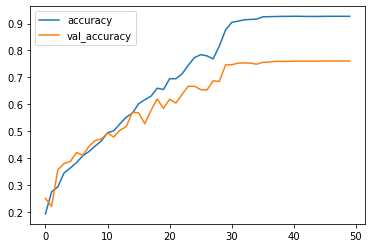

In [53]:
plt.plot(loss_history2["accuracy"],label="accuracy")
plt.plot(loss_history2["val_accuracy"],label="val_accuracy")
plt.legend()
plt.savefig("model2_acc.png")
plt.show()

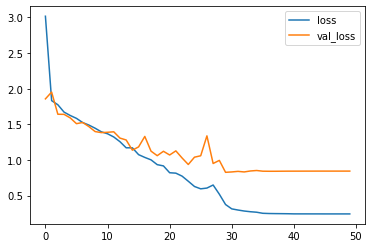

In [54]:
plt.plot(loss_history2["loss"],label="loss")
plt.plot(loss_history2["val_loss"],label="val_loss")
plt.legend()
plt.savefig("model2_loss.png")
plt.show()

In [91]:
model2.save('model2.h5')

In [37]:
model2 = tf.keras.models.load_model("model2.h5")
model2.evaluate(x_test,y_test)

45/45 [==============================] - 1s 3ms/step - loss: 0.8267 - accuracy: 0.7632


[0.8266710638999939, 0.7631944417953491]

The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)" by Livingstone & Russo is licensed under CC BY-NA-SC 4.0

<h2> model 3 </h2> <br />
we are adding batch normalization layer

In [92]:
def build_model3(shape):
    model=Sequential()
    model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(shape, 1)))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(BatchNormalization())
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(Flatten())
    model.add(Dense(256,activation="relu"))
    model.add(Dense(128,activation="relu"))
    model.add(Dense(8))
    model.add(Activation('softmax'))


    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [93]:
history3, model3 = train_model(build_model3)
loss_history3 = pd.DataFrame(history3.history)

Epoch 1/500
40/44 [==========================>...] - ETA: 0s - loss: 2.0322 - accuracy: 0.2093
Epoch 00001: val_accuracy did not improve from 0.80764
44/44 [==============================] - 1s 20ms/step - loss: 2.0152 - accuracy: 0.2141 - val_loss: 2.0172 - val_accuracy: 0.2111 - lr: 0.0010
Epoch 2/500
40/44 [==========================>...] - ETA: 0s - loss: 1.7857 - accuracy: 0.2865
Epoch 00002: val_accuracy did not improve from 0.80764
44/44 [==============================] - 1s 14ms/step - loss: 1.7811 - accuracy: 0.2894 - val_loss: 1.8769 - val_accuracy: 0.2667 - lr: 0.0010
Epoch 3/500
40/44 [==========================>...] - ETA: 0s - loss: 1.7273 - accuracy: 0.3113
Epoch 00003: val_accuracy did not improve from 0.80764
44/44 [==============================] - 1s 14ms/step - loss: 1.7297 - accuracy: 0.3130 - val_loss: 1.8263 - val_accuracy: 0.2944 - lr: 0.0010
Epoch 4/500
40/44 [==========================>...] - ETA: 0s - loss: 1.6992 - accuracy: 0.3363
Epoch 00004: val_accuracy 

Epoch 29/500
41/44 [==========================>...] - ETA: 0s - loss: 0.4701 - accuracy: 0.8261
Epoch 00029: val_accuracy did not improve from 0.80764
44/44 [==============================] - 1s 14ms/step - loss: 0.4744 - accuracy: 0.8266 - val_loss: 1.1156 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 30/500
41/44 [==========================>...] - ETA: 0s - loss: 0.5225 - accuracy: 0.8063
Epoch 00030: val_accuracy did not improve from 0.80764
44/44 [==============================] - 1s 14ms/step - loss: 0.5190 - accuracy: 0.8072 - val_loss: 1.1759 - val_accuracy: 0.6375 - lr: 0.0010
Epoch 31/500
41/44 [==========================>...] - ETA: 0s - loss: 0.4437 - accuracy: 0.8390
Epoch 00031: val_accuracy did not improve from 0.80764
44/44 [==============================] - 1s 14ms/step - loss: 0.4441 - accuracy: 0.8384 - val_loss: 0.9868 - val_accuracy: 0.6889 - lr: 0.0010
Epoch 32/500
41/44 [==========================>...] - ETA: 0s - loss: 0.4417 - accuracy: 0.8385
Epoch 00032: val_accur

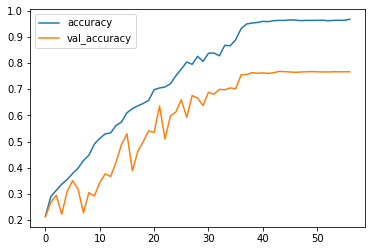

In [94]:
plt.plot(loss_history3["accuracy"],label="accuracy")
plt.plot(loss_history3["val_accuracy"],label="val_accuracy")
plt.legend()
plt.savefig("model3_acc.png")
plt.show()

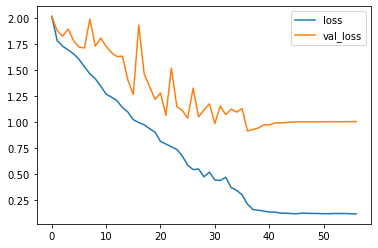

In [95]:
plt.plot(loss_history3["loss"],label="loss")
plt.plot(loss_history3["val_loss"],label="val_loss")
plt.legend()
plt.savefig("model3_loss.png")
plt.show()

In [96]:
model3.save('model3.h5')

In [97]:
model3 = tf.keras.models.load_model("model3.h5")

<h2> model 4 </h2> <br />
we are adding dropout layer

In [98]:
def build_model4(shape):
    model=Sequential()
    model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(shape, 1)))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Dropout(rate=0.25))
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(Flatten())
    model.add(Dense(256,activation="relu"))
    model.add(Dense(128,activation="relu"))
    model.add(Dense(8))
    model.add(Activation('softmax'))


    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [99]:
history4, model4 = train_model(build_model4)
loss_history4 = pd.DataFrame(history4.history)

Epoch 1/500
40/44 [==========================>...] - ETA: 0s - loss: 3.2728 - accuracy: 0.1803
Epoch 00001: val_accuracy did not improve from 0.80764
44/44 [==============================] - 1s 18ms/step - loss: 3.1698 - accuracy: 0.1836 - val_loss: 1.8534 - val_accuracy: 0.2979 - lr: 0.0010
Epoch 2/500
41/44 [==========================>...] - ETA: 0s - loss: 1.8581 - accuracy: 0.2578
Epoch 00002: val_accuracy did not improve from 0.80764
44/44 [==============================] - 1s 13ms/step - loss: 1.8553 - accuracy: 0.2604 - val_loss: 1.8266 - val_accuracy: 0.2785 - lr: 0.0010
Epoch 3/500
41/44 [==========================>...] - ETA: 0s - loss: 1.7768 - accuracy: 0.3017
Epoch 00003: val_accuracy did not improve from 0.80764
44/44 [==============================] - 1s 13ms/step - loss: 1.7771 - accuracy: 0.3000 - val_loss: 1.7388 - val_accuracy: 0.3049 - lr: 0.0010
Epoch 4/500
41/44 [==========================>...] - ETA: 0s - loss: 1.7278 - accuracy: 0.3076
Epoch 00004: val_accuracy 

Epoch 29/500
41/44 [==========================>...] - ETA: 0s - loss: 0.8213 - accuracy: 0.6920
Epoch 00029: val_accuracy did not improve from 0.80764
44/44 [==============================] - 1s 13ms/step - loss: 0.8216 - accuracy: 0.6914 - val_loss: 1.0921 - val_accuracy: 0.5951 - lr: 0.0010
Epoch 30/500
41/44 [==========================>...] - ETA: 0s - loss: 0.7687 - accuracy: 0.7110
Epoch 00030: val_accuracy did not improve from 0.80764
44/44 [==============================] - 1s 13ms/step - loss: 0.7692 - accuracy: 0.7120 - val_loss: 0.9279 - val_accuracy: 0.6625 - lr: 0.0010
Epoch 31/500
41/44 [==========================>...] - ETA: 0s - loss: 0.7288 - accuracy: 0.7349
Epoch 00031: val_accuracy did not improve from 0.80764
44/44 [==============================] - 1s 13ms/step - loss: 0.7275 - accuracy: 0.7370 - val_loss: 0.9968 - val_accuracy: 0.6444 - lr: 0.0010
Epoch 32/500
41/44 [==========================>...] - ETA: 0s - loss: 0.7336 - accuracy: 0.7254
Epoch 00032: val_accur

Epoch 57/500
41/44 [==========================>...] - ETA: 0s - loss: 0.2463 - accuracy: 0.9146
Epoch 00057: val_accuracy did not improve from 0.80764
44/44 [==============================] - 1s 13ms/step - loss: 0.2472 - accuracy: 0.9139 - val_loss: 0.7732 - val_accuracy: 0.7556 - lr: 1.0000e-05
Epoch 58/500
41/44 [==========================>...] - ETA: 0s - loss: 0.2366 - accuracy: 0.9193
Epoch 00058: val_accuracy did not improve from 0.80764
44/44 [==============================] - 1s 14ms/step - loss: 0.2359 - accuracy: 0.9201 - val_loss: 0.7726 - val_accuracy: 0.7549 - lr: 1.0000e-05
Epoch 59/500
41/44 [==========================>...] - ETA: 0s - loss: 0.2287 - accuracy: 0.9254
Epoch 00059: val_accuracy did not improve from 0.80764
44/44 [==============================] - 1s 13ms/step - loss: 0.2297 - accuracy: 0.9243 - val_loss: 0.7723 - val_accuracy: 0.7549 - lr: 1.0000e-06
Epoch 60/500
41/44 [==========================>...] - ETA: 0s - loss: 0.2389 - accuracy: 0.9163
Epoch 0006

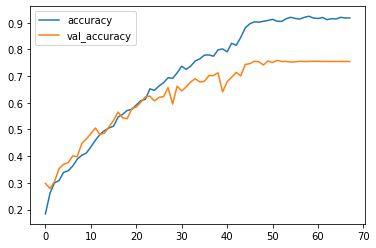

In [100]:
plt.plot(loss_history4["accuracy"],label="accuracy")
plt.plot(loss_history4["val_accuracy"],label="val_accuracy")
plt.legend()
plt.savefig("model4_acc.png")
plt.show()

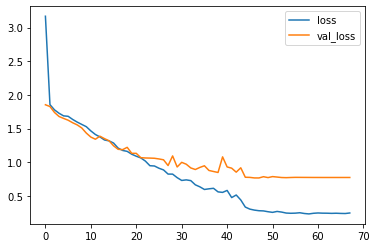

In [101]:
plt.plot(loss_history4["loss"],label="loss")
plt.plot(loss_history4["val_loss"],label="val_loss")
plt.legend()
plt.savefig("model4_loss.png")
plt.show()

In [102]:
model4.save('model4.h5')

In [103]:
model4 = tf.keras.models.load_model("model4.h5")

<h2> model 5 </h2> <br />
we are adding more dense layer

In [55]:
def build_model5(shape):
    model=Sequential()
    model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(shape, 1)))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Flatten())
    model.add(Dense(1024,activation="relu"))
    model.add(Dense(512,activation="relu"))
    model.add(Dense(128,activation="relu"))
    model.add(Dense(64,activation="relu"))
    model.add(Dense(16,activation="relu"))
    
    model.add(Dense(8))
    model.add(Activation('softmax'))


    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [57]:
history5, model5 = train_model(build_model5)
loss_history5 = pd.DataFrame(history5.history)

Epoch 1/500
41/44 [==========================>...] - ETA: 0s - loss: 2.5233 - accuracy: 0.1917
Epoch 00001: val_accuracy did not improve from 0.80764
44/44 [==============================] - 1s 20ms/step - loss: 2.4943 - accuracy: 0.1937 - val_loss: 1.9099 - val_accuracy: 0.2042 - lr: 0.0010
Epoch 2/500
41/44 [==========================>...] - ETA: 0s - loss: 1.8993 - accuracy: 0.2361
Epoch 00002: val_accuracy did not improve from 0.80764
44/44 [==============================] - 1s 16ms/step - loss: 1.8980 - accuracy: 0.2380 - val_loss: 1.8264 - val_accuracy: 0.3021 - lr: 0.0010
Epoch 3/500
41/44 [==========================>...] - ETA: 0s - loss: 1.8386 - accuracy: 0.2656
Epoch 00003: val_accuracy did not improve from 0.80764
44/44 [==============================] - 1s 16ms/step - loss: 1.8345 - accuracy: 0.2676 - val_loss: 1.7934 - val_accuracy: 0.3347 - lr: 0.0010
Epoch 4/500
41/44 [==========================>...] - ETA: 0s - loss: 1.8085 - accuracy: 0.2846
Epoch 00004: val_accuracy 

Epoch 29/500
41/44 [==========================>...] - ETA: 0s - loss: 0.7465 - accuracy: 0.7263
Epoch 00029: val_accuracy did not improve from 0.80764
44/44 [==============================] - 1s 16ms/step - loss: 0.7414 - accuracy: 0.7282 - val_loss: 1.1248 - val_accuracy: 0.6326 - lr: 0.0010
Epoch 30/500
41/44 [==========================>...] - ETA: 0s - loss: 0.7122 - accuracy: 0.7400
Epoch 00030: val_accuracy did not improve from 0.80764
44/44 [==============================] - 1s 16ms/step - loss: 0.7125 - accuracy: 0.7384 - val_loss: 1.0380 - val_accuracy: 0.6403 - lr: 0.0010
Epoch 31/500
41/44 [==========================>...] - ETA: 0s - loss: 0.6708 - accuracy: 0.7573
Epoch 00031: val_accuracy did not improve from 0.80764
44/44 [==============================] - 1s 16ms/step - loss: 0.6772 - accuracy: 0.7556 - val_loss: 1.3582 - val_accuracy: 0.6271 - lr: 0.0010
Epoch 32/500
41/44 [==========================>...] - ETA: 0s - loss: 0.7445 - accuracy: 0.7344
Epoch 00032: val_accur

Epoch 57/500
41/44 [==========================>...] - ETA: 0s - loss: 0.2021 - accuracy: 0.9346
Epoch 00057: val_accuracy did not improve from 0.80764
44/44 [==============================] - 1s 16ms/step - loss: 0.2046 - accuracy: 0.9336 - val_loss: 0.9970 - val_accuracy: 0.7493 - lr: 1.0000e-07
Epoch 58/500
41/44 [==========================>...] - ETA: 0s - loss: 0.2061 - accuracy: 0.9332 ETA: 0s - loss: 0.2083 
Epoch 00058: val_accuracy did not improve from 0.80764
Restoring model weights from the end of the best epoch: 38.
44/44 [==============================] - 1s 16ms/step - loss: 0.2046 - accuracy: 0.9336 - val_loss: 0.9970 - val_accuracy: 0.7486 - lr: 1.0000e-07
Epoch 00058: early stopping


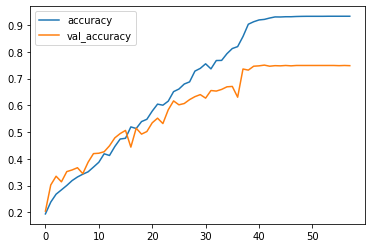

In [58]:
plt.plot(loss_history5["accuracy"],label="accuracy")
plt.plot(loss_history5["val_accuracy"],label="val_accuracy")
plt.legend()
plt.savefig("model5_acc.png")
plt.show()

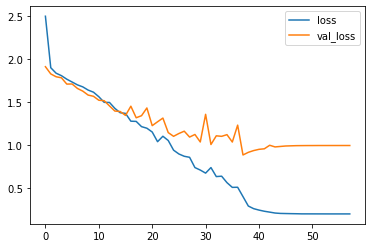

In [59]:
plt.plot(loss_history5["loss"],label="loss")
plt.plot(loss_history5["val_loss"],label="val_loss")
plt.legend()
plt.savefig("model5_loss.png")
plt.show()

In [60]:
model5.save('model5.h5')

In [61]:
model5 = tf.keras.models.load_model("model5.h5")

<h2> model6 </h2>

In [36]:
def build_model6(shape):
    model=Sequential()
    model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(shape, 1)))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Flatten())
    model.add(Dense(256,activation="relu"))
    model.add(Dense(128,activation="relu"))
    model.add(Dense(8))
    model.add(Activation('softmax'))


    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [37]:
history6, model6 = train_model(build_model6)
loss_history6 = pd.DataFrame(history6.history)

Epoch 1/500
44/44 [==============================] - ETA: 0s - loss: 2.6527 - accuracy: 0.1699
Epoch 00001: val_accuracy did not improve from 0.79167
44/44 [==============================] - 2s 21ms/step - loss: 2.6527 - accuracy: 0.1699 - val_loss: 1.9256 - val_accuracy: 0.2319 - lr: 0.0010
Epoch 2/500
40/44 [==========================>...] - ETA: 0s - loss: 1.8808 - accuracy: 0.24 - ETA: 0s - loss: 1.8856 - accuracy: 0.2440
Epoch 00002: val_accuracy did not improve from 0.79167
44/44 [==============================] - 1s 14ms/step - loss: 1.8782 - accuracy: 0.2477 - val_loss: 1.8427 - val_accuracy: 0.2854 - lr: 0.0010
Epoch 3/500
43/44 [============================>.] - ETA: 0s - loss: 1.8148 - accuracy: 0.2753
Epoch 00003: val_accuracy did not improve from 0.79167
44/44 [==============================] - 1s 14ms/step - loss: 1.8148 - accuracy: 0.2752 - val_loss: 1.7318 - val_accuracy: 0.3326 - lr: 0.0010
Epoch 4/500
43/44 [============================>.] - ETA: 0s - loss: 1.7731 - a

Epoch 55/500
44/44 [==============================] - ETA: 0s - loss: 0.1205 - accuracy: 0.9646
Epoch 00055: val_accuracy did not improve from 0.79167
44/44 [==============================] - 1s 14ms/step - loss: 0.1205 - accuracy: 0.9646 - val_loss: 0.8952 - val_accuracy: 0.7681 - lr: 1.0000e-07
Epoch 56/500
42/44 [===========================>..] - ETA: 0s - loss: 0.1202 - accuracy: 0.9645 ETA: 0s - loss: 0.1260 - accuracy: 
Epoch 00056: val_accuracy did not improve from 0.79167
44/44 [==============================] - 1s 14ms/step - loss: 0.1205 - accuracy: 0.9646 - val_loss: 0.8953 - val_accuracy: 0.7681 - lr: 1.0000e-07
Epoch 57/500
44/44 [==============================] - ETA: 0s - loss: 0.1205 - accuracy: 0.9646
Epoch 00057: val_accuracy did not improve from 0.79167
44/44 [==============================] - 1s 14ms/step - loss: 0.1205 - accuracy: 0.9646 - val_loss: 0.8953 - val_accuracy: 0.7681 - lr: 1.0000e-07
Epoch 58/500
40/44 [==========================>...] - ETA: 0s - loss: 

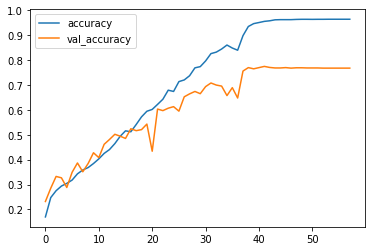

In [38]:
plt.plot(loss_history6["accuracy"],label="accuracy")
plt.plot(loss_history6["val_accuracy"],label="val_accuracy")
plt.legend()
plt.savefig("model6_acc.png")
plt.show()


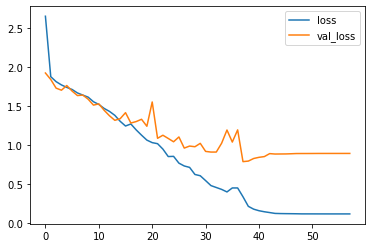

In [39]:
plt.plot(loss_history6["loss"],label="loss")
plt.plot(loss_history6["val_loss"],label="val_loss")
plt.legend()
plt.savefig("model6_loss.png")
plt.show()

In [40]:
model6.save('model6.h5')

In [68]:
model6 = tf.keras.models.load_model("model6.h5")

<h2> model 7 </h2>

In [57]:
def build_model7(shape):
    model=Sequential()
    model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(shape, 1)))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(Flatten())
    model.add(Dense(256,activation="relu"))
    model.add(Dense(128,activation="relu"))
    model.add(Dense(8))
    model.add(Activation('softmax'))


    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [58]:
history7, model7 = train_model(build_model7)
loss_history7 = pd.DataFrame(history7.history)

Epoch 1/500
40/44 [==========================>...] - ETA: 0s - loss: 2.9994 - accuracy: 0.1887
Epoch 00001: val_accuracy did not improve from 0.79167
44/44 [==============================] - 1s 13ms/step - loss: 2.9225 - accuracy: 0.1898 - val_loss: 1.8926 - val_accuracy: 0.2340 - lr: 0.0010
Epoch 2/500
43/44 [============================>.] - ETA: 0s - loss: 1.8666 - accuracy: 0.2656
Epoch 00002: val_accuracy did not improve from 0.79167
44/44 [==============================] - 0s 9ms/step - loss: 1.8670 - accuracy: 0.2648 - val_loss: 1.7927 - val_accuracy: 0.3000 - lr: 0.0010
Epoch 3/500
43/44 [============================>.] - ETA: 0s - loss: 1.7601 - accuracy: 0.2991
Epoch 00003: val_accuracy did not improve from 0.79167
44/44 [==============================] - 0s 9ms/step - loss: 1.7604 - accuracy: 0.2991 - val_loss: 1.6683 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 4/500
43/44 [============================>.] - ETA: 0s - loss: 1.6715 - accuracy: 0.3523
Epoch 00004: val_accuracy di

Epoch 29/500
43/44 [============================>.] - ETA: 0s - loss: 0.3508 - accuracy: 0.8809
Epoch 00029: val_accuracy did not improve from 0.79167
44/44 [==============================] - 0s 9ms/step - loss: 0.3505 - accuracy: 0.8810 - val_loss: 0.8127 - val_accuracy: 0.7451 - lr: 0.0010
Epoch 30/500
43/44 [============================>.] - ETA: 0s - loss: 0.3803 - accuracy: 0.8686
Epoch 00030: val_accuracy did not improve from 0.79167
44/44 [==============================] - 0s 9ms/step - loss: 0.3799 - accuracy: 0.8687 - val_loss: 0.8369 - val_accuracy: 0.7389 - lr: 0.0010
Epoch 31/500
43/44 [============================>.] - ETA: 0s - loss: 0.3226 - accuracy: 0.8960 ETA: 0s - loss: 0.3192 - accuracy
Epoch 00031: val_accuracy did not improve from 0.79167
44/44 [==============================] - 0s 9ms/step - loss: 0.3218 - accuracy: 0.8961 - val_loss: 0.9719 - val_accuracy: 0.7104 - lr: 0.0010
Epoch 32/500
43/44 [============================>.] - ETA: 0s - loss: 0.3501 - accuracy

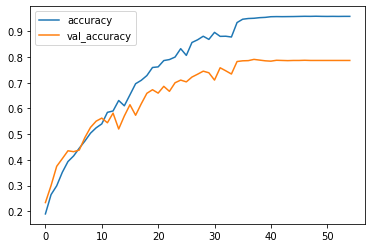

In [59]:
plt.plot(loss_history7["accuracy"],label="accuracy")
plt.plot(loss_history7["val_accuracy"],label="val_accuracy")
plt.legend()
plt.savefig("model7_acc.png")
plt.show()

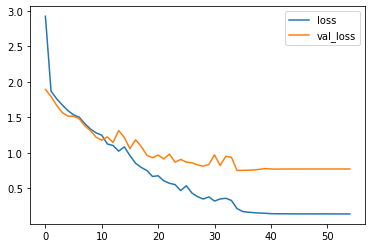

In [60]:
plt.plot(loss_history7["loss"],label="loss")
plt.plot(loss_history7["val_loss"],label="val_loss")
plt.legend()
plt.savefig("model7_loss.png")
plt.show()

In [61]:
model7.save('model7.h5')

In [62]:
model7 = tf.keras.models.load_model("model7.h5")

# try other non-ann models

In [59]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn import neighbors

<h2> final model </h2>

In [19]:
def train_final(build_model):
    model = build_model(shape)
    history=model.fit(x_train, y_train, batch_size=100, epochs=200, validation_data=(x_val, y_val))
    return history, model

In [24]:
def build_final(shape):
    model=Sequential()
    model.add(Conv1D(16, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(shape, 1)))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Dropout(rate=0.5))
    model.add(Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Dropout(rate=0.5))
    model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Dropout(rate=0.5))
    model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Dropout(rate=0.5))
    model.add(Flatten())
    model.add(Dense(256,activation="relu"))
    model.add(Dense(128,activation="relu"))
    model.add(Dense(64,activation="relu"))
    model.add(Dense(8))
    model.add(Activation('softmax'))
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)


    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr_schedule), metrics=['accuracy'])

    return model

In [25]:
final_history, final_model = train_final(build_final)
final_loss_history = pd.DataFrame(final_history.history)

Epoch 1/200
44/44 [==============================] - 1s 14ms/step - loss: 5.2903 - accuracy: 0.1354 - val_loss: 2.0791 - val_accuracy: 0.1312
Epoch 2/200
44/44 [==============================] - 0s 6ms/step - loss: 2.1514 - accuracy: 0.1361 - val_loss: 2.0734 - val_accuracy: 0.1764
Epoch 3/200
44/44 [==============================] - 0s 7ms/step - loss: 2.1085 - accuracy: 0.1391 - val_loss: 2.0718 - val_accuracy: 0.1375
Epoch 4/200
44/44 [==============================] - 0s 7ms/step - loss: 2.0708 - accuracy: 0.1613 - val_loss: 2.0643 - val_accuracy: 0.1535
Epoch 5/200
44/44 [==============================] - 0s 7ms/step - loss: 2.0526 - accuracy: 0.1704 - val_loss: 2.0455 - val_accuracy: 0.1597
Epoch 6/200
44/44 [==============================] - 0s 7ms/step - loss: 2.0289 - accuracy: 0.1831 - val_loss: 2.0255 - val_accuracy: 0.1590
Epoch 7/200
44/44 [==============================] - 0s 7ms/step - loss: 2.0065 - accuracy: 0.1727 - val_loss: 1.9968 - val_accuracy: 0.1583
Epoch 8/200


Epoch 59/200
44/44 [==============================] - 0s 7ms/step - loss: 1.7316 - accuracy: 0.3090 - val_loss: 1.7391 - val_accuracy: 0.3313
Epoch 60/200
44/44 [==============================] - 0s 7ms/step - loss: 1.7418 - accuracy: 0.3106 - val_loss: 1.7646 - val_accuracy: 0.3313
Epoch 61/200
44/44 [==============================] - 0s 6ms/step - loss: 1.7322 - accuracy: 0.3148 - val_loss: 1.7751 - val_accuracy: 0.3236
Epoch 62/200
44/44 [==============================] - 0s 7ms/step - loss: 1.7354 - accuracy: 0.3157 - val_loss: 1.7813 - val_accuracy: 0.3187
Epoch 63/200
44/44 [==============================] - 0s 7ms/step - loss: 1.7348 - accuracy: 0.3074 - val_loss: 1.7580 - val_accuracy: 0.3375
Epoch 64/200
44/44 [==============================] - 0s 7ms/step - loss: 1.7230 - accuracy: 0.3111 - val_loss: 1.7665 - val_accuracy: 0.3264
Epoch 65/200
44/44 [==============================] - 0s 7ms/step - loss: 1.7189 - accuracy: 0.3139 - val_loss: 1.7830 - val_accuracy: 0.3104
Epoch 

44/44 [==============================] - 0s 7ms/step - loss: 1.6449 - accuracy: 0.3502 - val_loss: 1.8243 - val_accuracy: 0.2847
Epoch 117/200
44/44 [==============================] - 0s 6ms/step - loss: 1.6467 - accuracy: 0.3456 - val_loss: 1.8132 - val_accuracy: 0.3014
Epoch 118/200
44/44 [==============================] - 0s 6ms/step - loss: 1.6496 - accuracy: 0.3400 - val_loss: 1.7952 - val_accuracy: 0.3063
Epoch 119/200
44/44 [==============================] - 0s 7ms/step - loss: 1.6552 - accuracy: 0.3435 - val_loss: 1.8175 - val_accuracy: 0.3049
Epoch 120/200
44/44 [==============================] - 0s 7ms/step - loss: 1.6495 - accuracy: 0.3435 - val_loss: 1.8475 - val_accuracy: 0.2778
Epoch 121/200
44/44 [==============================] - 0s 7ms/step - loss: 1.6534 - accuracy: 0.3442 - val_loss: 1.7943 - val_accuracy: 0.3014
Epoch 122/200
44/44 [==============================] - 0s 7ms/step - loss: 1.6452 - accuracy: 0.3484 - val_loss: 1.7976 - val_accuracy: 0.2910
Epoch 123/200

44/44 [==============================] - 0s 6ms/step - loss: 1.5803 - accuracy: 0.3794 - val_loss: 1.8961 - val_accuracy: 0.2833
Epoch 174/200
44/44 [==============================] - 0s 6ms/step - loss: 1.5894 - accuracy: 0.3706 - val_loss: 1.9751 - val_accuracy: 0.2632
Epoch 175/200
44/44 [==============================] - 0s 7ms/step - loss: 1.5927 - accuracy: 0.3708 - val_loss: 2.0142 - val_accuracy: 0.2528
Epoch 176/200
44/44 [==============================] - 0s 6ms/step - loss: 1.5708 - accuracy: 0.3796 - val_loss: 2.0106 - val_accuracy: 0.2771
Epoch 177/200
44/44 [==============================] - 0s 6ms/step - loss: 1.5719 - accuracy: 0.3912 - val_loss: 1.9854 - val_accuracy: 0.2583
Epoch 178/200
44/44 [==============================] - 0s 7ms/step - loss: 1.5801 - accuracy: 0.3699 - val_loss: 1.9699 - val_accuracy: 0.2639
Epoch 179/200
44/44 [==============================] - 0s 6ms/step - loss: 1.5824 - accuracy: 0.3650 - val_loss: 1.9586 - val_accuracy: 0.2771
Epoch 180/200

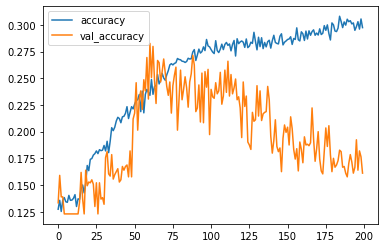

In [22]:
plt.plot(final_loss_history["accuracy"],label="accuracy")
plt.plot(final_loss_history["val_accuracy"],label="val_accuracy")
plt.legend()
plt.savefig("final_model_acc.png")
plt.show()

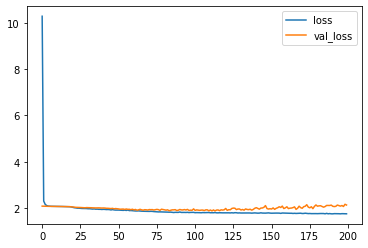

In [23]:
plt.plot(final_loss_history["loss"],label="loss")
plt.plot(final_loss_history["val_loss"],label="val_loss")
plt.legend()
plt.savefig("final_model_loss.png")
plt.show()

In [58]:
final_model.save('final_model.h5')

NameError: name 'model8' is not defined

In [121]:
final_model = tf.keras.models.load_model("final_model.h5")

In [ ]:
#json.dump(mul_historys[i].history,open("./historys/compare_multiple_aug_"+' '.join([str(elem) for elem in sorted_augs[:i+1]]),'w'))
#json.load(open("./historys/final_aug",'r'))